## map2loop: Hamersely maps

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into a mdelling engine to make a 3D model 


## Choose map area
1. Run cell below
2. Select map area from drop down menu   
3. Click in next cell and run next cells to define modelling engine run to end using menu:  
   *Cell->Run all below*


In [3]:
import ipywidgets as widgets
import os

import sys
sys.path.append('../../map2loop')

# load last saved map area and mdoe engine (if they exist)
if(os.path.isfile('../last_choices.txt')):
    f=open('../last_choices.txt','r')
    contents =f.readlines()
    f.close()
    default_map=contents[0].replace("\n","")
    default_engine=contents[1].replace("\n","")
else:
    default_map='test_data3'
    default_engine='loopstructural'

map_choice=widgets.Dropdown(
    options=['test_data3','Turner_Syncline'],
    value=default_map,
    description='Map area:',
    disabled=False,
)
display(map_choice)

Dropdown(description='Map area:', options=('test_data3', 'Turner_Syncline'), value='test_data3')

In [4]:
test_data_name=map_choice.value
print(test_data_name)


test_data3


## Choose model engine
1. Run cell below
2. Select modelling engine from drop down menu   
3. Click in next cell and run to end using menu: *Cell->Run all below* 

In [5]:
engine_choice=widgets.Dropdown(
    options=['geomodeller', 'gempy','loopstructural','noddy','null'],
    value=default_engine,
    description='Modeller:',
    disabled=False,
)
display(engine_choice)

Dropdown(description='Modeller:', index=1, options=('geomodeller', 'gempy', 'loopstructural', 'noddy', 'null')…

In [6]:
workflow={'model_engine':engine_choice.value} 
print(workflow['model_engine'])
# save last map and engine choices
f=open('../last_choices.txt','w') 
ostr=str(map_choice.value)+'\n'+str(engine_choice.value)+'\n'
f.write(ostr)
f.close()

gempy


In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()


In [8]:
contacts = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\AUS_GA_1M_Contacts.geojson')
print("contacts")
faults = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\AUS_GA_1M_Faults.geojson')
print("faults")
lithology = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\AUS_GA_1M_GUPoly_Lithology.geojson')
print("lithology")
#age = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\AUS_GA_1M_GUPoly_Age.geojson')
#print("age")
minocc = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\shpMinOccGA.shp')
print("minocc")
print("finished Geology Load")   
structures = gpd.read_file(r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\StructuresPoint.shp')
print("structures")

faults
lithology
minocc
finished Big Load
structures


In [71]:
faults.head(1)

,objectid,typename,type_uri,fltname,descr,exposure,faultfill,defrmstyle,defrm_uri,mvttype,mvttyp_uri,mvtsense,dsplcmnt,dip,dipdirn,width,geolhist,repage_uri,yngage_uri,oldage_uri,fltsys,fltsysid,obsmethod,confidence,posacc_m,source,metadata,frame,resscale,captscale,captdate,moddate,plotrank,featcode,featureid,faultid,st_length(shape),geometry
0,1,fault,http://resource.geosciml.org/classifier/cgi/fa...,NEWTOWN FAULT,"fault, concealed",concealed,unknown,unknown,http://www.opengis.net/def/nil/OGC/0/unknown,None,http://www.opengis.net/def/nil/OGC/0/unknown,None,None,None,None,None,None,http://www.opengis.net/def/nil/OGC/0/unknown,http://www.opengis.net/def/nil/OGC/0/unknown,http://www.opengis.net/def/nil/OGC/0/unknown,None,None,synthesis of multiple published descriptions,None,1000,"VandenBerg AHM, 1999. Victoria 1:1 000 000 Geo...",http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,1000000,2005-07-27,2012-09-12,1,1100104,GA_GSDL1M_0033600,GA.FaultShear.SurfaceGeology1M.GA_GSDL1M_0033600,0.002849,"MULTILINESTRING ((144.32330 -38.15181, 144.324..."


In [10]:
print(faults['faultfill'].value_counts())
print(faults['defrmstyle'].value_counts())
print(faults['descr'].value_counts())

unknown     103929
mylonite        23
Name: faultfill, dtype: int64
unknown    103439
ductile       513
Name: defrmstyle, dtype: int64
fault                    82656
fault, concealed         20783
shear zone                 464
shear zone, concealed       49
Name: descr, dtype: int64


In [11]:
lithology.head(1)

,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,...,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(shape),st_perimeter(shape),geometry
0,1,Nssp,Ns,26904,Spearhole Formation,Cross bedded poorly sorted granule and pebble ...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,...,land surface,1000000,2008-11-27,2008-11-27,1,GA_GUP1M_0058707,GA.GeologicUnit.SurfaceGeology1M.26904,0.002426,0.395991,"MULTIPOLYGON (((120.46770 -24.37326, 120.46983..."


In [12]:
print(lithology['descr'].value_counts())

Colluvium and/or residual deposits, sheetwash, talus, scree; boulder, gravel, sand; may include minor alluvial or sand plain deposits, local calcrete and reworked laterite                                                                                23794
Sand or gravel plains; may include some residual alluvium; quartz sand sheets commonly with ferruginous pisoliths or pebbles; local clay, calcrete, laterite, silcrete, silt, colluvium                                                                    14132
Ferruginous duricrust, laterite; pisolitic, nodular, vuggy; may include massive to pisolitic ferruginous subsoil, mottled clays, magnesite, reworked products of ferruginous and siliceous duricrusts, calcrete, gossan; residual ferruginous saprolite    13964
Channel and flood plain alluvium; gravel, sand, silt, clay; may be locally calcreted                                                                                                                                                 

In [13]:
structures.head(1)

,identifier,sitename,observatio,label,descriptio,featureofi,observedpr,observedva,observedv0,observati0,...,modeofoccu,state,country,gda94_long,gda94_lat,elevation_,observati1,project,kml_locati,geometry
0,ga.fieldsite.2288248.16153,93834267,structural measurement,93834267.generic foliation,None,generic foliation,declination/azimuth,80/98,degrees,field site observation,...,None,Queensland,Australia,143.73449,-16.166356,223.0,1993-07-22 00:00:00,None,<Point><extrude>0</extrude><tessellate>0</tess...,POINT (143.73449 -16.16636)


In [14]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
minocc.head(1)

,FID,OTHERID,NAME,PROJECT,CLASS,STATE,COMMODS,COMMDNAMES,LONGITUDE,LATITUDE,ACCURACY,EASTING,NORTHING,ZONE,LOC_METHOD,HMAPNO,HMAPNAME,QMAPID,QMAPNAME,SOURCE,GEOM,geometry
0,mineral_occurrences.1140901,201439,Brogo Sand & Gravel Pit,None,None,NSW,"Gvl, Aggc, Sdc","Gravel, Aggregate - coarse, Sand - construction",149.842,-36.6005,100,754213,5945683,None,None,8824,BEGA,SJ5504,BEGA,MacRae G.P. (1994) - GS1994/093,POINT (-36.600492 149.841954),None


In [15]:
print(minocc['CLASS'].value_counts())
print(minocc['NAME'].value_counts())
print(minocc['PROJECT'].value_counts())

Production Centre                     17081
ABANDONED MINE                        15373
Mine - Unspecified                    12497
Mine - Openpit                         5442
MINERAL OCCURRENCE                     5069
Mine or Prospect                       3430
Construction Materials                 3341
Deposit - Unspecified                  3076
Occurrence - Unspecified               3057
MINE                                   2233
Mineral occurrence                     1989
Prospect - Unspecified                 1859
Prospect - Drillhole                   1554
PIT                                    1150
PROSPECT                               1087
QUARRY                                  976
Mine - Shaft                            942
Abandoned mine                          914
OCCURRENCE                              772
Occurrence - Outcrop                    754
Area of alluvial workings               734
OPERATING MINE                          610
Occurrence                      

In [16]:
structuresRichard = structures.copy()
structuresRichard[['Declination','Azimuth']] = structures.observedva.str.split('/',expand=True) 

In [17]:
print(lithology['descr'].value_counts().size)
print(lithology['descr'].value_counts())

5375
Colluvium and/or residual deposits, sheetwash, talus, scree; boulder, gravel, sand; may include minor alluvial or sand plain deposits, local calcrete and reworked laterite                                                                                23794
Sand or gravel plains; may include some residual alluvium; quartz sand sheets commonly with ferruginous pisoliths or pebbles; local clay, calcrete, laterite, silcrete, silt, colluvium                                                                    14132
Ferruginous duricrust, laterite; pisolitic, nodular, vuggy; may include massive to pisolitic ferruginous subsoil, mottled clays, magnesite, reworked products of ferruginous and siliceous duricrusts, calcrete, gossan; residual ferruginous saprolite    13964
Channel and flood plain alluvium; gravel, sand, silt, clay; may be locally calcreted                                                                                                                                            

In [18]:
import urllib.request
from tqdm import tqdm as tqdm

#print(lithology['descr'].value_counts().size)
#print(lithology['descr'].value_counts())
print(lithology['yngage_uri'].unique().size)
yngage = lithology['yngage_uri'].unique().tolist()
agehtml = []
#yngage[1]

for age in tqdm(yngage):
    try:
        uf = urllib.request.urlopen(age)
        html = uf.read()
        agehtml.append(html)
    except Exception as urlfail:
        print(urlfail)
        print(age)
        agehtml.append("Fail_" + age)

  0%|                                                                                          | 0/132 [00:00<?, ?it/s]

132


 42%|██████████████████████████████████▎                                              | 56/132 [00:27<00:29,  2.60it/s]

HTTP Error 404: Not Found
http://resource.geosciml.org/classifier/ics/ischart/CambrianStage7


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [01:03<00:00,  2.09it/s]

HTTP Error 404: Not Found
http://resource.geosciml.org/classifier/ics/ischart/CambrianStage9


In [19]:
#!pip install lxml
from bs4 import BeautifulSoup
bound_age_yng = []
bound_age_old = []
for index, html in tqdm(enumerate(agehtml)):
    soup = BeautifulSoup(html, "html.parser")
    #res = soup.findAll({"class":"comment"})
    #print(soup.title)
    gdp_table = soup.find("tr", attrs={"class": "comment"})
    #gdp_table = soup.find("td", attrs={"class": "value"})
    headings = []
    #print(len(gdp_table))
    #print(yngage[index])
    #if gdp_table and len(gdp_table) > 1:
    if gdp_table:
        count = 0
        for td in gdp_table.find_all("td", attrs={"class": "value"}):
            count = count + 1
            #print(count)
            #print(td.text)
        #print(gdp_table)
            if "older bound" in td.text and count > 1:
                #print(td.text.strip())
                tdstr = td.text.replace("older bound ", "")
                rest = tdstr.split(" ", 1)[0]
                rest = rest.replace("-","")
                bound_age_old.append(rest)
            if "younger bound" in td.text and count > 1:
                tdstr = td.text.replace("younger bound ", "")
                rest = tdstr.split(" ", 1)[0]
                rest = rest.replace("-","")
                #print(td.text.strip())
                bound_age_yng.append(rest)
    else:
        bound_age_old.append("Fail_" + yngage[index])     
        bound_age_yng.append("Fail_" + yngage[index])     
        #print(res)


132it [00:03, 40.70it/s]


In [20]:
#for old in bound_age_old:
    #print(old)
print(len(bound_age_yng))    
#for old in bound_age_yng:
    #print(old)

numeric_yng = {}    
numeric_old = {}
for index, age in enumerate(yngage):
    numeric_yng[age] = bound_age_yng[index]
    numeric_old[age] = bound_age_old[index]
    
print(numeric_yng)    
#!pip install bs4
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianStage2'] = 529
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/Terreneuvian'] = 541
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/Thanetian'] = 59.2

#numeric_yng['Fail_http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 514
#numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 521
numeric_yng['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 514
numeric_old['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3'] = 521

#Fail_http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries3



132
{'http://resource.geosciml.org/classifier/ics/ischart/Cryogenian': '635', 'http://resource.geosciml.org/classifier/ics/ischart/Quaternary': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Holocene': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Paleoproterozoic': '1600', 'http://resource.geosciml.org/classifier/ics/ischart/LowerCretaceous': '100.5', 'http://resource.geosciml.org/classifier/ics/ischart/Neoproterozoic': '541.0', 'http://resource.geosciml.org/classifier/ics/ischart/Cenozoic': '0.0', 'http://resource.geosciml.org/classifier/ics/ischart/Cisuralian': '272.95', 'http://resource.geosciml.org/classifier/ics/ischart/Statherian': '1600', 'http://resource.geosciml.org/classifier/ics/ischart/UpperOrdovician': '443.8', 'http://resource.geosciml.org/classifier/ics/ischart/Cretaceous': '66.0', 'http://resource.geosciml.org/classifier/ics/ischart/Archean': '2500', 'http://resource.geosciml.org/classifier/ics/ischart/Lopingian': '251.902', 'http://resource.

In [21]:
def set_value(row_number, assigned_value): 
    #print(row_number)
    return assigned_value[row_number] 

In [22]:
print(minocc.shape)
type(minocc)

(119468, 22)


geopandas.geodataframe.GeoDataFrame

In [23]:
minocc = minocc[~minocc.is_empty]   
print(minocc.shape)
minocc = minocc[~minocc.isna()]   
print(minocc.shape)

(119468, 22)
(119468, 22)


In [27]:
minocc['geometry'].isna().size
print(minocc.crs)
minocc['GEOM'].head(5)

epsg:4283


0    POINT (-36.600492 149.841954)
1    POINT (-32.681432 151.541986)
2    POINT (-35.218068 149.422735)
3    POINT (-34.034479 151.157474)
4    POINT (-31.439602 152.700125)
Name: GEOM, dtype: object

In [30]:
print(minocc.crs) #check to see, make them all consistent
minocc = minocc.to_crs(epsg=4326)

epsg:4283


AttributeError: 'NoneType' object has no attribute 'is_empty'

In [28]:
xmin = 130.8333
ymin = -13.25
xmax = 131.25
ymax = -12.75

def aoi_box(dfBroad, xmin, xmax, ymin, ymax):
    dfAoi = dfBroad.cx[xmin:xmax, ymin:ymax]
    return dfAoi

#browns area
lithology_Browns = aoi_box(lithology, xmin, xmax, ymin, ymax)
faults_Browns = aoi_box(faults, xmin, xmax, ymin, ymax)
structures_Browns = aoi_box(structures, xmin, xmax, ymin, ymax)
minocc_Browns = aoi_box(minocc, xmin, xmax, ymin, ymax)

#get details for Curnamona area of interest

In [29]:
lithology_Browns_UTM = lithology_Browns.to_crs(epsg=28352)
faults_Browns_UTM = faults_Browns.to_crs(epsg=28352)
structures_Browns_UTM = structures_Browns.to_crs(epsg=28352)
minocc_Browns_UTM = minocc_Browns.to_crs(epsg=28352)

In [30]:
print(lithology_Browns_UTM.shape,faults_Browns_UTM.shape,structures_Browns_UTM.shape,minocc_Browns_UTM.shape)

(232, 29) (354, 38) (0, 36) (0, 22)


In [45]:
shape_path = r'C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles' + "\\"
lithology_Browns_UTM.to_file(shape_path + 'lithology_Browns_UTM.shp')
faults_Browns_UTM.to_file(shape_path + 'faults_Browns_UTM.shp')
if structures_Browns_UTM.shape[0] > 0:
    structures_Browns_UTM.to_file(shape_path + 'structures_Browns_UTM.shp')
if minocc_Browns_UTM.shape[0] > 0:    
    minocc_Browns_UTM.to_file(shape_path + 'minocc_Browns_UTM.shp')

In [31]:
#https://services.sarig.sa.gov.au/vector/geology/wfs?service=wfs&version=1.1.0&REQUEST=GetCapabilities
with rasterio.open(r'C:\users\rscott\Downloads\test1.tif') as CURNAMONA:
    print(CURNAMONA.meta)
    

#test1.tif

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6291, 'height': 7626, 'count': 7, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, 139.30579352719275,
       0.0, -0.00026949458523585647, -29.97561322119908)}


In [32]:
print (CURNAMONA.bounds    )
xminC, yminC, xmaxC, ymaxC = CURNAMONA.bounds
print(xminC)

lithology_Curnamona = aoi_box(lithology, xminC, xmaxC, yminC, ymaxC)
faults_Curnamona = aoi_box(faults, xminC, xmaxC, yminC, ymaxC)
structures_Curnamona = aoi_box(structures, xminC, xmaxC, yminC, ymaxC)
minocc_Curnamona = aoi_box(minocc, xminC, xmaxC, yminC, ymaxC)

BoundingBox(left=139.30579352719275, bottom=-32.030778928207724, right=141.0011839629115, top=-29.97561322119908)
139.30579352719275


In [33]:
lithology_Curnamona_UTM = lithology_Curnamona.to_crs(epsg=28354)
faults_Curnamona_UTM = faults_Curnamona.to_crs(epsg=28354)
structures_Curnamona_UTM = structures_Curnamona.to_crs(epsg=28354)
minocc_Curnamona_UTM = minocc_Curnamona.to_crs(epsg=28354)

In [34]:
lithology_Curnamona_UTM.head()
#print(numeric_old)

,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,yngage_uri,oldage_uri,lithology,replith_uri,morphology,obsmethod,confidence,source,metadata,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(shape),st_perimeter(shape),geometry
382,367,EOlh,EOl,8159,Hawker Group,"Limestone, siltstone, shale; lesser sandstone,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,sedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,"MULTIPOLYGON (((338500.080 6534596.290, 338473..."
449,427,Nsc,Ns,3338,Callanna Group,"Siltstone, locally carbonaceous; sandstone, lo...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,argillaceous detrital sediment; quartz-rich ar...,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,"MULTIPOLYGON (((337607.730 6661780.900, 337994..."
1111,1083,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,regolith,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,"MULTIPOLYGON (((398599.684 6498514.088, 398580..."
2011,1967,Mgbb,Mg,69582,Bimbowrie Suite,"Monzogranite, biotite-muscovite.",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,igneous felsic intrusive,http://resource.geosciml.org/classifier/cgi/li...,intrusion,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,"MULTIPOLYGON (((424656.808 6461680.622, 424773..."
2130,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,metasedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,"MULTIPOLYGON (((422956.356 6468018.144, 422924..."


In [35]:
lithology_Curnamona_UTM['yngage'] = lithology_Curnamona_UTM['yngage_uri'].apply(set_value, args =(numeric_yng, )) 
lithology_Curnamona_UTM['oldage'] = lithology_Curnamona_UTM['oldage_uri'].apply(set_value, args =(numeric_old, )) 

In [36]:
lithology_Curnamona_UTM['yngage'].unique()

array(['509', '635', '0.0', '1000', '1600', '1400', '5.333', '0.0117',
       '541.0', 514, '298.9', '433.4', '66.0', '37.8'], dtype=object)

In [37]:
print(lithology_Curnamona_UTM.shape,faults_Curnamona_UTM.shape,structures_Curnamona_UTM.shape,minocc_Curnamona_UTM.shape)

(504, 31) (96, 38) (19, 36) (0, 22)


In [42]:
lithology_Curnamona_UTM.to_file(shape_path + 'lithology_Curnamona_UTM.shp')
faults_Curnamona_UTM.to_file(shape_path + 'faults_Curnamona_UTM.shp')
if structures_Curnamona_UTM.shape[0] > 0:
    structures_Curnamona_UTM.to_file(shape_path + 'structures_Curnamona_UTM.shp')
if minocc_Curnamona_UTM.shape[0] > 0:    
    minocc_Curnamona_UTM.to_file(shape_path + 'minocc_Curnamona_UTM.shp')

## Load config file

In [38]:
lithology_Browns_UTM.total_bounds
lithology_Curnamona_UTM.total_bounds

array([ 261137.8498951 , 5918968.94714117, 1538726.54120686,
       7674308.52382104])

In [72]:
test_data_path='../'+test_data_name+'/'
test_data_path = shape_path

os.chdir(test_data_path)
%run -i "m2l_config_richard_GA.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())
minx = lithology_Browns_UTM.total_bounds[0]
miny = lithology_Browns_UTM.total_bounds[1]
maxx = lithology_Browns_UTM.total_bounds[2]
maxy = lithology_Browns_UTM.total_bounds[3]

minx = lithology_Curnamona_UTM.total_bounds[0]
miny = lithology_Curnamona_UTM.total_bounds[1]
maxx = lithology_Curnamona_UTM.total_bounds[2]
maxy = lithology_Curnamona_UTM.total_bounds[3]

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\m2l_config.py:
#ROI


#LL -13 15, 130 50
#UR = -12 45,131 15


step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

#possible selection of UTM zones for standard Australian locations or Brazil?
minx=680323  #region of interest coordinates in metre-based system (or non-degree system)
maxx=794478
miny=8497197
maxy=8636847
model_top=1200
model_base=-3200

#PATHS

local_paths=True       #flag to use local or WFS source for data inputs (True = local)

data_path='../source_data/'

#geology_file='hams2_geol.shp'   #input geology file (if local)
geology_file='lithology_Curnamona_UTM.shp'
#fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
fault_file='faults_Curnamona_UTM.shp'
#structure_file='hams2_structure.shp' #input bedding orientation file (if local)
structure_file='structures_Curnamona_UTM

<Figure size 432x288 with 0 Axes>

In [77]:
# opportunity to second guess config file or add extra parameters not yet in config file...

fold_decimate=2         

fault_decimate=0

contact_decimate=5

orientation_decimate=0

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=90

min_fault_length=5000

compute_etc=False

spacing=500   #grid spacing in metres of interpolation points


local_paths=True

#################################
# There are many alternative datasets that 
# can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow 
# will be for this experiment, based partly 
# on which (if any) modelling engine is used
#
#############################################


if(workflow['model_engine']=='geomodeller'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':True} )
elif(workflow['model_engine']=='loopstructural'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':True} )
elif(workflow['model_engine']=='gempy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
elif(workflow['model_engine']=='noddy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
else:
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
    


# no cover info so no need load cover layers
if(not workflow['cover_map']):
    dtb=0
    dtb_null=0
else:
    dtb_grid=data_path+'young_cover_grid.tif' #obviously hard-wired for the moment
    dtb_null='-2147483648' #obviously hard-wired for the moment
    cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp' #obviously hard-wired for the moment
    dtb_clip=output_path+'young_cover_grid_clip.tif' #obviously hard-wired for the moment
    cover_dip=10 # dip of cover away from contact
    spacing=5000 # of contact grid in metres


## First we test to see if we have access to the online data we need


In [78]:
#geol=gpd.read_file('../source_data/hamms_roi.shp', bbox=bbox)
#geol=gpd.read_file('C:/Users/rscott/Documents/Exploracorn/Australia/s3/exploracorn/shapefiles/lithology_browns_UTM.shp', bbox=bbox)
#geol=gpd.read_file('C:/Users/rscott/Documents/Exploracorn/Australia/s3/exploracorn/shapefiles/lithology_browns_UTM.shp')
geol=gpd.read_file('C:/Users/rscott/Documents/Exploracorn/Australia/s3/exploracorn/shapefiles/lithology_Curnamona_UTM.shp')
display(geol)
display(bbox)


,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,yngage_uri,oldage_uri,lithology,replith_ur,morphology,obsmethod,confidence,source,metadata,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(sh,st_perimet,yngage,oldage,geometry
0,367,EOlh,EOl,8159,Hawker Group,"Limestone, siltstone, shale; lesser sandstone,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,sedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,509,529,"POLYGON ((338500.080 6534596.290, 338473.900 6..."
1,427,Nsc,Ns,3338,Callanna Group,"Siltstone, locally carbonaceous; sandstone, lo...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,argillaceous detrital sediment; quartz-rich ar...,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,635,720,"POLYGON ((337607.730 6661780.900, 337994.100 6..."
2,1083,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,regolith,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,0.0,0.0117,"POLYGON ((398599.684 6498514.088, 398580.933 6..."
3,1967,Mgbb,Mg,69582,Bimbowrie Suite,"Monzogranite, biotite-muscovite.",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,igneous felsic intrusive,http://resource.geosciml.org/classifier/cgi/li...,intrusion,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,1000,1600,"POLYGON ((424656.808 6461680.622, 424773.119 6..."
4,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,metasedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,1600,1800,"POLYGON ((422956.356 6468018.144, 422924.319 6..."
...,...,...,...,...,...,...,...,...,...,..

(261137.849895105, 5918968.947141168, 1538726.5412068614, 7674308.523821039)

In [79]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
ga=m2l_utils.have_access("services.ga.gov.au")
if(not local_paths and not loopwfs):
    raise NameError('map2loop error: No access to remote map server')
if(not (loopwfs & ga)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: services.ga.gov.au


##  Check Map for valid input files   
   
### Checks for:   
- Files exist
- Requred fields
- No NaN/blanks in required fields
- Sufficient orientation data
- LineString/PolyLines for faults (i.e. not MultiLineStrings/MultiPolylines), if found splits into unique ID polylines
- Commas in unit code (maybe should check in groups and alt groups??

### Should also check for:   
- Significantly overlapping polygons
- Faults that should be joined (c.f. FracG code)
- Orientations near contacts that make no sense (i.e. strike is at high angle to contact tangent)



In [50]:
structures_Curnamona_UTM
structures_Curnamona_UTM.dropna(subset=['declinatio'], inplace=True)
structures_Curnamona_UTM.to_file(shape_path + 'structures_Curnamona_UTM.shp')

In [51]:
print(lithology_Curnamona_UTM['yngage_uri'].values)
lithology_Curnamona_UTM.head()

['http://resource.geosciml.org/classifier/ics/ischart/CambrianSeries2'
 'http://resource.geosciml.org/classifier/ics/ischart/Cryogenian'
 'http://resource.geosciml.org/classifier/ics/ischart/Holocene'
 'http://resource.geosciml.org/classifier/ics/ischart/Mesoproterozoic'
 'http://resource.geosciml.org/classifier/ics/ischart/Statherian'
 'http://resource.geosciml.org/classifier/ics/ischart/Statherian'
 'http://resource.geosciml.org/classifier/ics/ischart/Calymmian'
 'http://resource.geosciml.org/classifier/ics/ischart/Quaternary'
 'http://resource.geosciml.org/classifier/ics/ischart/Miocene'
 'http://resource.geosciml.org/classifier/ics/ischart/Cryogenian'
 'http://resource.geosciml.org/classifier/ics/ischart/Holocene'
 'http://resource.geosciml.org/classifier/ics/ischart/Quaternary'
 'http://resource.geosciml.org/classifier/ics/ischart/Calymmian'
 'http://resource.geosciml.org/classifier/ics/ischart/Miocene'
 'http://resource.geosciml.org/classifier/ics/ischart/Holocene'
 'http://resou

,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,yngage_uri,oldage_uri,lithology,replith_uri,morphology,obsmethod,confidence,source,metadata,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(shape),st_perimeter(shape),geometry,yngage,oldage
382,367,EOlh,EOl,8159,Hawker Group,"Limestone, siltstone, shale; lesser sandstone,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,sedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,"MULTIPOLYGON (((338500.080 6534596.290, 338473...",509,529
449,427,Nsc,Ns,3338,Callanna Group,"Siltstone, locally carbonaceous; sandstone, lo...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,argillaceous detrital sediment; quartz-rich ar...,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,"MULTIPOLYGON (((337607.730 6661780.900, 337994...",635,720
1111,1083,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,regolith,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,"MULTIPOLYGON (((398599.684 6498514.088, 398580...",0.0,0.0117
2011,1967,Mgbb,Mg,69582,Bimbowrie Suite,"Monzogranite, biotite-muscovite.",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,igneous felsic intrusive,http://resource.geosciml.org/classifier/cgi/li...,intrusion,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,"MULTIPOLYGON (((424656.808 6461680.622, 424773...",1000,1600
2130,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,metasedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,"MULTIPOLYGON (((422956.356 6468018.144, 422924...",1600,1800


In [80]:
structure_file = shape_path + 'StructuresPoint.shp'
geology_file = shape_path + 'lithology_browns_UTM.shp'
fault_file = shape_path + 'faults_browns_UTM.shp'  
mindep_file = shape_path +  'shpMinOccGA.shp'
#Curnamona
structure_file = shape_path + 'structures_Curnamona_UTM.shp'
geology_file = shape_path + 'lithology_Curnamona_UTM.shp'
fault_file = shape_path + 'faults_Curnamona_UTM.shp'  
mindep_file = shape_path +  'minocc_Curnamona_UTM.shp'  #None here
mindep_file = shape_path +  'shpMinOccGA.shp'

m2l_map_checker.check_map(structure_file,geology_file,fault_file,mindep_file,tmp_path,bbox,c_l,dst_crs,local_paths)

No errors found


## Display stereonets of bedding by formations and group to see how we can combine them later

In [53]:
print(structure_file)
orientations = gpd.read_file(structure_file,bbox=bbox)
orientations.head()
print(len(orientations))
print(bbox)
print(orientations.crs)

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\structures_Curnamona_UTM.shp
8
(261137.849895105, 5918968.947141168, 1538726.5412068614, 7674308.523821039)
epsg:28354


8
                   identifier    sitename              observatio  \
0  ga.fieldsite.1579290.92990  2002181297  structural measurement   
1  ga.fieldsite.1586046.92393  2002181031  structural measurement   
2  ga.fieldsite.1586046.92392  2002181031  structural measurement   
3  ga.fieldsite.1586046.92391  2002181031  structural measurement   
4  ga.fieldsite.1575625.92991  2002181303  structural measurement   

                             label  \
0           2002181297.gneissosity   
1  2002181031.crenulation cleavage   
2  2002181031.crenulation cleavage   
3  2002181031.crenulation cleavage   
4        2002181303.planar bedding   

                                          descriptio            featureofi  \
0  Stratigraphic unit inferred from 1:1M scale Su...           gneissosity   
1                                               None  crenulation cleavage   
2                                               None  crenulation cleavage   
3                                         

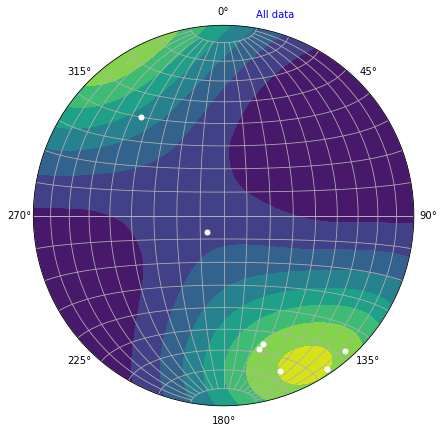

----------------------------------------------------------------------------------------------------------------------
Hawker Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
Callanna Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
alluvium 38485 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Bimbowrie Suite observations has no observations
----------------------------------------------------------------------------------------------------------------------
Curnamona Group observations n= 4
strike/dip of girdle 153.8519637575496 / 76.85129167712108


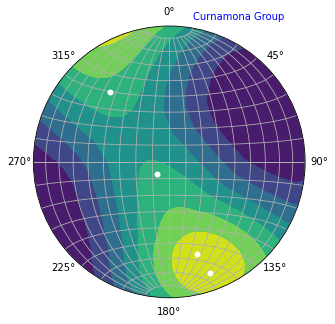

----------------------------------------------------------------------------------------------------------------------
Strathearn Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
dunes 38496 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Namba Formation observations has no observations
----------------------------------------------------------------------------------------------------------------------
Wooltana Volcanics observations has no observations
----------------------------------------------------------------------------------------------------------------------
colluvium 38491 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Eurinilla Formation observations has no o

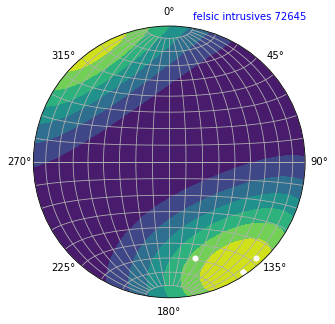

----------------------------------------------------------------------------------------------------------------------
Yudnamutana Subgroup observations has no observations
----------------------------------------------------------------------------------------------------------------------
Lake Frome Group observations has no observations
----------------------------------------------------------------------------------------------------------------------
lake deposits 38492 observations has no observations
----------------------------------------------------------------------------------------------------------------------
Terrapinna Granite observations has no observations
----------------------------------------------------------------------------------------------------------------------
Arrowie Formation observations has no observations
----------------------------------------------------------------------------------------------------------------------
Willawortina Formation obs

In [54]:

geology = gpd.read_file(geology_file,bbox=bbox)

geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)

orientations = gpd.read_file(structure_file,bbox=bbox)
print(len(orientations))
print(orientations.head())
if(len(orientations)<2):
    raise NameError('Not enough orientations to complete calculations (need at least 2)')
group_girdle=m2l_utils.plot_bedding_stereonets(orientations,geology,c_l)


## Test code to automatically create super_groups and use_group3

In [55]:
from math import acos, degrees

group_girdle =pd.DataFrame.from_dict(group_girdle,orient='index')
group_girdle.columns = ['plunge', 'bearing', 'num orientations']
group_girdle.sort_values(by='num orientations', ascending=False,inplace=True)
display(group_girdle)


l,m,n=m2l_utils.ddd2dircos(group_girdle.iloc[0]['plunge'],group_girdle.iloc[0]['bearing'])
super_group=pd.DataFrame([[group_girdle[0:1].index[0],'Super_Group_0',l,m,n]],columns=['Group','Super_Group','l','m','n'])
super_group.set_index('Group',inplace=True)

print('---------------------------------')
sg_index=0
for i in range(1,len(group_girdle)):
    l,m,n=m2l_utils.ddd2dircos(group_girdle.iloc[i]['plunge'],group_girdle.iloc[i]['bearing'])
    found=False
    sg_i=0
    for ind,sg in super_group.iterrows():
        
        c = sg['l']*l + sg['m']*m + sg['n']*n
        if c>1:
            c=1
        c=degrees(acos(c))  

        if(c<30  and not found):
            found=True
            sgname='Super_Group_'+str(sg_i)
            super_group_old=pd.DataFrame([[group_girdle[i:i+1].index[0],sgname,l,m,n]],columns=['Group','Super_Group','l','m','n'])
            super_group_old.set_index('Group',inplace=True)
            super_group=super_group.append(super_group_old)
        sg_i=sg_i+1
        
    if(not found):

        sg_index=sg_index+1
        #print('not found',sg_index)
        sgname='Super_Group_'+str(sg_index)
        super_group_new=pd.DataFrame([[group_girdle[i:i+1].index[0],sgname,l,m,n]],columns=['Group','Super_Group','l','m','n'])
        super_group_new.set_index('Group',inplace=True)
        super_group=super_group.append(super_group_new)

display(super_group)  


use_gcode3=[]
for ind,sg in super_group.iterrows():
    clean=ind.replace(" ","_").replace("-","_")
    use_gcode3.append(clean)

display(use_gcode3)

sg2=set(super_group['Super_Group'])
display(sg2)
super_groups=[]
for s in sg2:
    temp=[]
    for  ind,sg in super_group.iterrows():
        if(s == sg['Super_Group']):
            temp.append(ind)
    super_groups.append(temp)

display(super_groups)

,plunge,bearing,num orientations
Curnamona Group,13.148708,63.851964,4
felsic intrusives 72645,39.311503,50.120249,4
Hawker Group,-999.000000,-999.000000,0
Yerelina Subgroup,-999.000000,-999.000000,0
sedimentary rocks 72357,-999.000000,-999.000000,0
Golden Pole Granite,-999.000000,-999.000000,0
Radium Creek Metamorphics,-999.000000,-999.000000,0
felsic intrusives 72695,-999.000000,-999.000000,0
Crocker Well Suite,-999.000000,-999.000000,0
Pooraka Formation,-999.000000,-999.000000,0


---------------------------------


,Super_Group,l,m,n
Group,,,,
Curnamona Group,Super_Group_0,0.204199,0.100248,0.973783
felsic intrusives 72645,Super_Group_0,0.486170,0.406210,0.773713
Hawker Group,Super_Group_1,0.975528,0.154508,0.156434
Yerelina Subgroup,Super_Group_2,0.975528,0.154508,0.156434
sedimentary rocks 72357,Super_Group_2,0.975528,0.154508,0.156434
Golden Pole Granite,Super_Group_2,0.975528,0.154508,0.156434
Radium Creek Metamorphics,Super_Group_2,0.975528,0.154508,0.156434
felsic intrusives 72695,Super_Group_2,0.975528,0.154508,0.156434
Crocker Well Suite,Super_Group_2,0.975528,0.154508,0.156434


['Curnamona_Group',
 'felsic_intrusives_72645',
 'Hawker_Group',
 'Yerelina_Subgroup',
 'sedimentary_rocks_72357',
 'Golden_Pole_Granite',
 'Radium_Creek_Metamorphics',
 'felsic_intrusives_72695',
 'Crocker_Well_Suite',
 'Pooraka_Formation',
 'Mount_Neill_Granite',
 'British_Empire_Granite',
 'Telford_Gravel',
 'Parabarana_Sandstone',
 'Umberatana_Group',
 'Moolawatana_Suite',
 'Saltbush_Subgroup',
 'Pound_Subgroup',
 'Pepegoona_Porphyry',
 'Freeling_Heights_Quartzite,_Mount_Adams_Quartzite,_Yagdlin_Phyllite',
 'Nooldoonooldoona_Trondhjemite',
 'Box_Bore_Granite',
 'Warragee_Member',
 'Wattleowie_Granite',
 'Burra_Group',
 'Radium_Ridge_Breccia,_Mount_Gee_Sinter',
 'Callanna_Group',
 'Basso_Suite',
 'alluvium_38485',
 'Bimbowrie_Suite',
 'Strathearn_Group',
 'dunes_38496',
 'Namba_Formation',
 'Wooltana_Volcanics',
 'colluvium_38491',
 'Eurinilla_Formation',
 'sand_plain_38499',
 'Millyera_Formation',
 'Wilpena_Group',
 'lunette_dunes_72955',
 'Emeroo_Subgroup',
 'Yudnamutana_Subgroup'

{'Super_Group_0', 'Super_Group_1', 'Super_Group_2'}

[['Curnamona Group', 'felsic intrusives 72645'],
 ['Yerelina Subgroup',
  'sedimentary rocks 72357',
  'Golden Pole Granite',
  'Radium Creek Metamorphics',
  'felsic intrusives 72695',
  'Crocker Well Suite',
  'Pooraka Formation',
  'Mount Neill Granite',
  'British Empire Granite',
  'Telford Gravel',
  'Parabarana Sandstone',
  'Umberatana Group',
  'Moolawatana Suite',
  'Saltbush Subgroup',
  'Pound Subgroup',
  'Pepegoona Porphyry',
  'Freeling Heights Quartzite, Mount Adams Quartzite, Yagdlin Phyllite',
  'Nooldoonooldoona Trondhjemite',
  'Box Bore Granite',
  'Warragee Member',
  'Wattleowie Granite',
  'Burra Group',
  'Radium Ridge Breccia, Mount Gee Sinter',
  'Callanna Group',
  'Basso Suite',
  'alluvium 38485',
  'Bimbowrie Suite',
  'Strathearn Group',
  'dunes 38496',
  'Namba Formation',
  'Wooltana Volcanics',
  'colluvium 38491',
  'Eurinilla Formation',
  'sand plain 38499',
  'Millyera Formation',
  'Wilpena Group',
  'lunette dunes 72955',
  'Emeroo Subgroup',
 

## Decide on super groups and groups
Supergroups define what shall be interpolated as single system   
use_gcode defines which groups we choose to calculate model from  

<font color='red'>The following outputs are the default settings that put all groups as one super_group for orientation interpolation purposes and use_gcode3 defines which groups will actually be modelled If after looking at the stereonets you want to change these defaults, just copy paste the two following lines into the next cell below and edit them as you wish. </font>  

In [56]:

print("super_groups=",super_groups)
print("use_gcode3=",use_gcode3)


super_groups= [['Curnamona Group', 'felsic intrusives 72645'], ['Yerelina Subgroup', 'sedimentary rocks 72357', 'Golden Pole Granite', 'Radium Creek Metamorphics', 'felsic intrusives 72695', 'Crocker Well Suite', 'Pooraka Formation', 'Mount Neill Granite', 'British Empire Granite', 'Telford Gravel', 'Parabarana Sandstone', 'Umberatana Group', 'Moolawatana Suite', 'Saltbush Subgroup', 'Pound Subgroup', 'Pepegoona Porphyry', 'Freeling Heights Quartzite, Mount Adams Quartzite, Yagdlin Phyllite', 'Nooldoonooldoona Trondhjemite', 'Box Bore Granite', 'Warragee Member', 'Wattleowie Granite', 'Burra Group', 'Radium Ridge Breccia, Mount Gee Sinter', 'Callanna Group', 'Basso Suite', 'alluvium 38485', 'Bimbowrie Suite', 'Strathearn Group', 'dunes 38496', 'Namba Formation', 'Wooltana Volcanics', 'colluvium 38491', 'Eurinilla Formation', 'sand plain 38499', 'Millyera Formation', 'Wilpena Group', 'lunette dunes 72955', 'Emeroo Subgroup', 'Yudnamutana Subgroup', 'Lake Frome Group', 'lake deposits 384

## Preprocess data to ensure it meets modelling requirements

In [57]:
print('only processing',use_gcode3)

inputs=('')

if(workflow['model_engine'] =='geomodeller'):
    inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations','fault_tip_contacts','contact_orientations')
elif(workflow['model_engine']=='loopstructural'):
    inputs=('invented_orientations','fat_orientations','contact_orientations')
elif(workflow['model_engine']=='gempy'):
    inputs=('invented_orientations','interpolated_orientations','fat_orientations')
elif(workflow['model_engine']=='noddy'):
    inputs=('')

only processing ['Curnamona_Group', 'felsic_intrusives_72645', 'Hawker_Group', 'Yerelina_Subgroup', 'sedimentary_rocks_72357', 'Golden_Pole_Granite', 'Radium_Creek_Metamorphics', 'felsic_intrusives_72695', 'Crocker_Well_Suite', 'Pooraka_Formation', 'Mount_Neill_Granite', 'British_Empire_Granite', 'Telford_Gravel', 'Parabarana_Sandstone', 'Umberatana_Group', 'Moolawatana_Suite', 'Saltbush_Subgroup', 'Pound_Subgroup', 'Pepegoona_Porphyry', 'Freeling_Heights_Quartzite,_Mount_Adams_Quartzite,_Yagdlin_Phyllite', 'Nooldoonooldoona_Trondhjemite', 'Box_Bore_Granite', 'Warragee_Member', 'Wattleowie_Granite', 'Burra_Group', 'Radium_Ridge_Breccia,_Mount_Gee_Sinter', 'Callanna_Group', 'Basso_Suite', 'alluvium_38485', 'Bimbowrie_Suite', 'Strathearn_Group', 'dunes_38496', 'Namba_Formation', 'Wooltana_Volcanics', 'colluvium_38491', 'Eurinilla_Formation', 'sand_plain_38499', 'Millyera_Formation', 'Wilpena_Group', 'lunette_dunes_72955', 'Emeroo_Subgroup', 'Yudnamutana_Subgroup', 'Lake_Frome_Group', 'la

## Plot geology polygons and bounding box

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\lithology_Curnamona_UTM.shp


,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,yngage_uri,oldage_uri,lithology,replith_ur,morphology,obsmethod,confidence,source,metadata,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(sh,st_perimet,yngage,oldage,geometry
0,367,EOlh,EOl,8159,Hawker Group,"Limestone, siltstone, shale; lesser sandstone,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,sedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.228110,509,529,"POLYGON ((338500.080 6534596.290, 338473.900 6..."
1,427,Nsc,Ns,3338,Callanna Group,"Siltstone, locally carbonaceous; sandstone, lo...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,argillaceous detrital sediment; quartz-rich ar...,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058204,GA.GeologicUnit.SurfaceGeology1M.3338,0.000921,0.340800,635,720,"POLYGON ((337607.730 6661780.900, 337994.100 6..."
2,1083,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,regolith,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0057560,GA.GeologicUnit.SurfaceGeology1M.38485,0.011165,3.363716,0.0,0.0117,"POLYGON ((398599.684 6498514.088, 398580.933 6..."
3,1967,Mgbb,Mg,69582,Bimbowrie Suite,"Monzogranite, biotite-muscovite.",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Mesoproterozoic,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,igneous felsic intrusive,http://resource.geosciml.org/classifier/cgi/li...,intrusion,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043071,GA.GeologicUnit.SurfaceGeology1M.69582,0.000883,0.201596,1000,1600,"POLYGON ((424656.808 6461680.622, 424773.119 6..."
4,2082,Lnwc,Ln,35326,Curnamona Group,Metasediments characterised by calc-silicate m...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,metasedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0043848,GA.GeologicUnit.SurfaceGeology1M.35326,0.000189,0.071282,1600,1800,"POLYGON ((422956.356 6468018.144, 422924.319 6..."


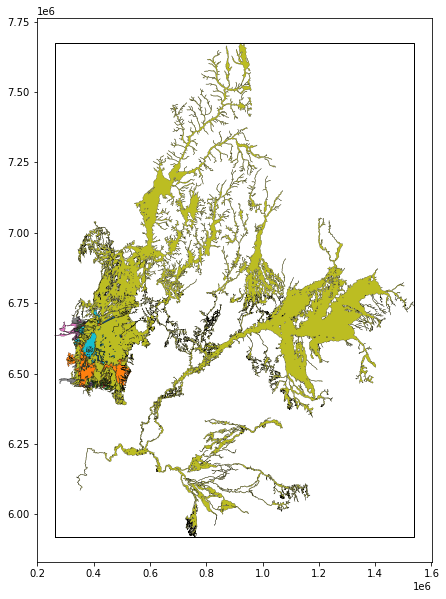

In [58]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

geology_ll[c_l['g']].fillna(geology_ll[c_l['g2']], inplace=True)
geology_ll[c_l['g']].fillna(geology_ll[c_l['c']], inplace=True)
display(geology_ll.head())
base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [77]:
geology_ll.head(1)

,objectid,mapsymbol,plotsymbol,stratno,name,descr,typename,type_uri,geolhist,repage_uri,yngage_uri,oldage_uri,lithology,replith_ur,morphology,obsmethod,confidence,source,metadata,frame,resscale,captdate,moddate,plotrank,featureid,geolunitid,st_area(sh,st_perimet,yngage,oldage,geometry
0,367,EOlh,EOl,8159,Hawker Group,"Limestone, siltstone, shale; lesser sandstone,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Tommotian to Early Cambrian,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,http://resource.geosciml.org/classifier/ics/is...,sedimentary carbonate,http://resource.geosciml.org/classifier/cgi/li...,None,synthesis of multiple published descriptions,None,http://www.ga.gov.au/products-services/data-ap...,http://www.ga.gov.au/metadata-gateway/metadata...,land surface,1000000,2008-07-11,2008-07-11,1,GA_GUP1M_0058037,GA.GeologicUnit.SurfaceGeology1M.8159,0.001464,0.22811,509,529,"POLYGON ((338500.080 6534596.290, 338473.900 6..."


In [78]:
#print(geology_ll[[c_l['min']]])
lithology_Curnamona_UTM['yngage'].unique().tolist()
print(geology_file_csv)

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/lithology_Curnamona_UTM.csv


In [79]:
hint_flag=False # use GSWA strat database to provide relative age hints
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

504  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

0  points


C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\site-packages\geopandas\plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


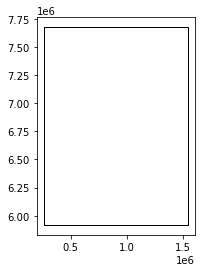

In [80]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save orientations data point data as WKT

8  points


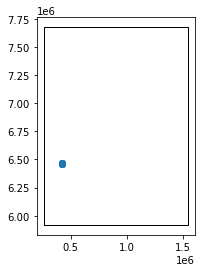

In [81]:
orientations = gpd.read_file(structure_file,bbox=bbox)

sub_pts = orientations[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

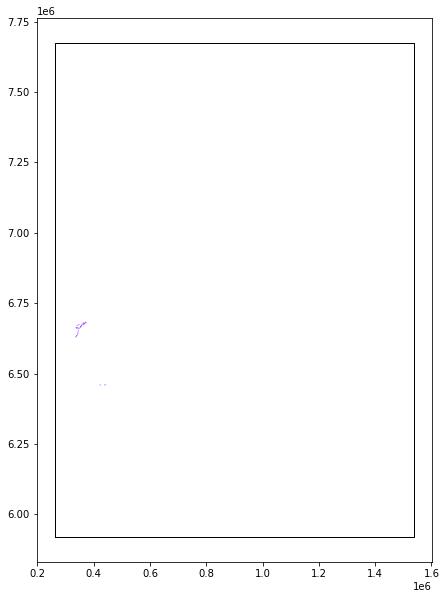

In [82]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [83]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

96  polylines


In [86]:
print(geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv)
print(m2m_cpp_path,c_l,graph_path)
print(minx,maxx,miny,maxy)

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/lithology_Curnamona_UTM.csv C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/faults_Curnamona_UTM.csv C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/structures_Curnamona_UTM.csv C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/shpMinOccGA.csv
../m2m_cpp/ {'d': 'declinatio', 'dd': 'azimuth', 'sf': 'featureofi', 'bedding': 'bedding', 'otype': 'dip direction', 'g': 'name', 'g2': 'plotsymbol', 'c': 'mapsymbol', 'ds': 'descr', 'u': 'typename', 'r1': 'lithology', 'r2': 'replith_ur', 'sill': 'sill', 'intrusive': 'intrusive', 'volcanic': 'volcanic', 'msc': 'OTHERID', 'msn': 'NAME', 'mst': 'CLASS', 'mtc': 'COMMDNAMES', 'mscm': 'COMMODS', 'mcom': 'COMMDNAMES', 'minf': 'Production', 'min': 'yngage', 'max': 'oldage', 'f': 'descr', 'fault': 'fault', 'fold': 'fold', 'fdip': 'dip', 'fdipnull': 'None', 'fdipdir': 'dipdir', 'fdipdir_flag'

## Create map2model input file

In [89]:
print(m2m_cpp_path)
m2m_cpp_path = r'C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\m2m_cpp' + "\\"
print(m2m_cpp_path)

C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\m2m_cpp\
C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\m2m_cpp\


In [90]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE')


## Calculate topology

In [91]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"])
else:
    subprocess.run(["./map2model", "Parfile"])

C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\m2m_cpp


## Simple network graph of the geology with legend

In [92]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

0    'EOlh'
1    'Nsc'
2    'Qa'
3    'Mgbb'
4    'Lnwc'
5    'Lnwr'
6    'Qd'
7    'Czcna'
8    'Nbcw'
9    'Qrc'
10    'Qteu'
11    'Czs'
12    'Qtmi'
13    'Nswl'
14    'Qdlu'
15    'Nsbe'
16    'Lg'
17    'Nsuu'
18    'EOsf'
19    'Qt'
20    'Mgmp'
21    'Qsar'
22    'Czcwi'
23    'Lgba'
24    'Cqrg'
25    'Nsu'
26    'Nsbr'
27    'Czc'
28    'Mgmg'
29    'Lnrc'
30    'Mg'
31    'Mgcr'
32    'Qrcp'
33    'Mgbn'
34    'OSgbe'
35    'Qste'
36    'Nsuy'
37    'Ksp'
38    'Mgm'
39    'Lnwab'
40    'Nswp'
41    'Mgpe'
42    'Myfy'
43    'Mgbo'
44    'Mgmb'
45    'Esfw'
46    'Mgmi'
47    'Czcey'


## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>




C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\map2loop
C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\map2loop


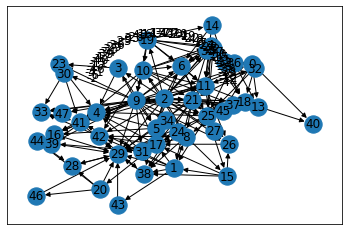

In [93]:
os.chdir('../map2loop')

print(os.getcwd())

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


## Next we define an area of interest and some other basic stuff

In [94]:
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


C:\Users\rscott\OneDrive - OZ Minerals\Exploration\Research\gostin\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

138.22113763774385 152.64755060752086 -36.945029291448556 -20.641662286194745


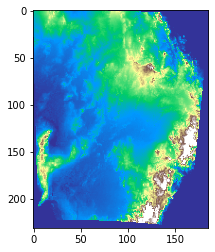

In [62]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if(((not os.path.exists(dtm_file)) or (not local_paths)) and net):    
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(dtm_reproj_file)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=0,vmax=1000)
pyplot.show()

## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

../../map2loop\map2loop\m2l_topology.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(p+1) #display strat graph for one group


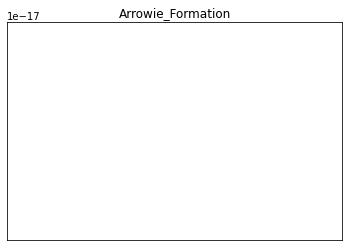

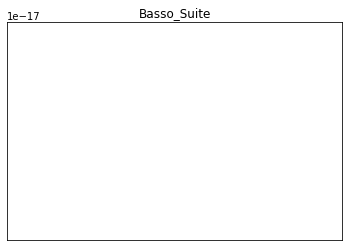

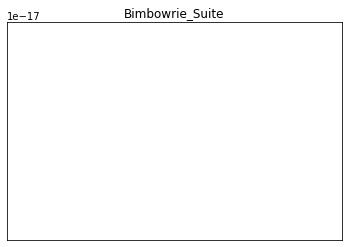

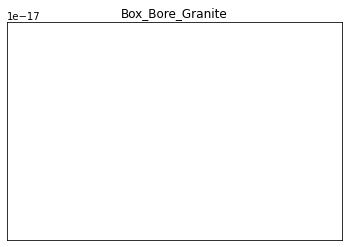

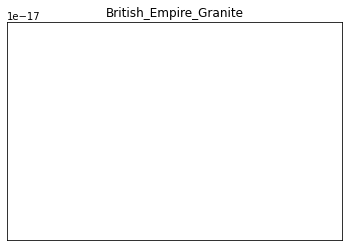

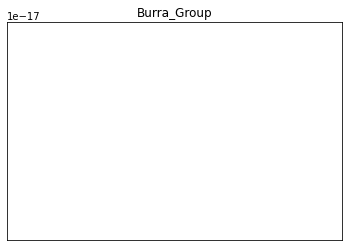

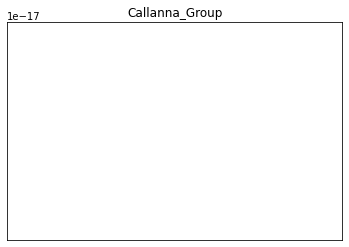

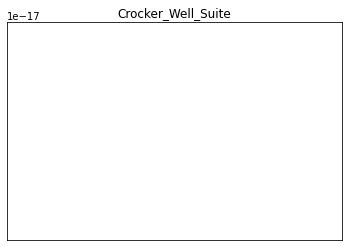

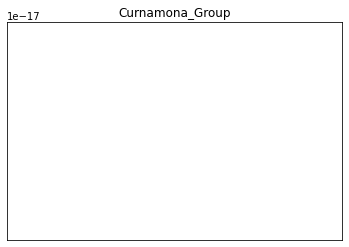

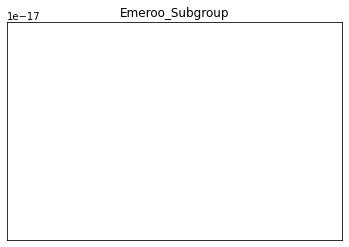

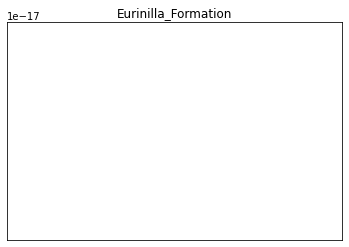

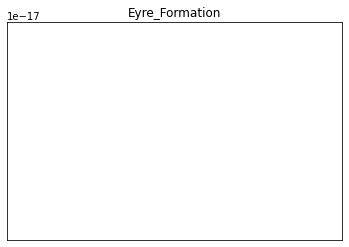

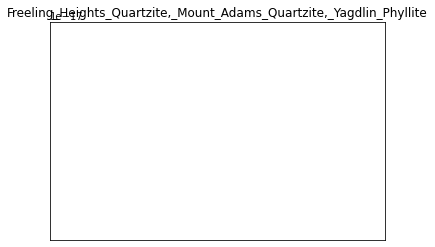

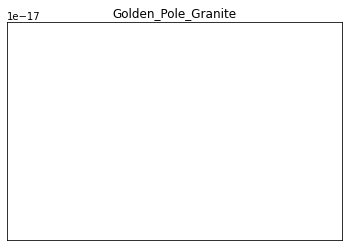

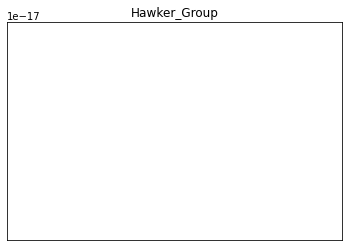

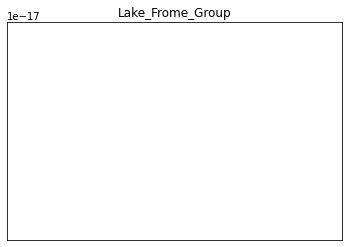

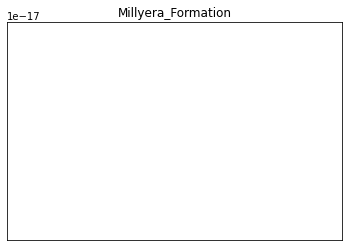

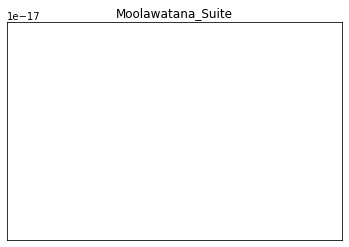

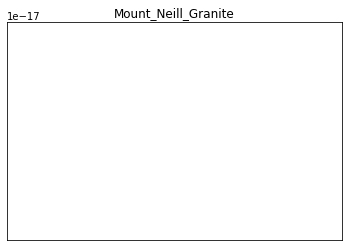

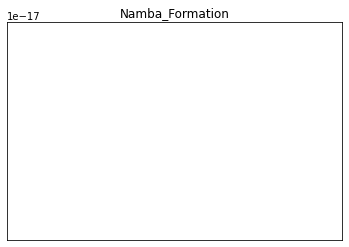

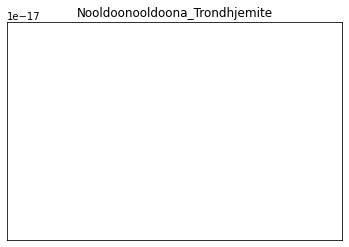

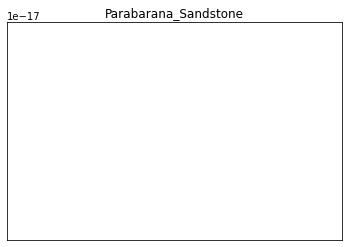

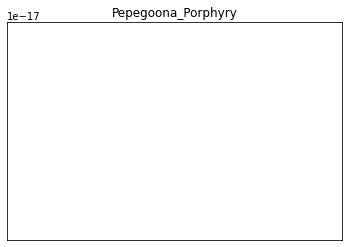

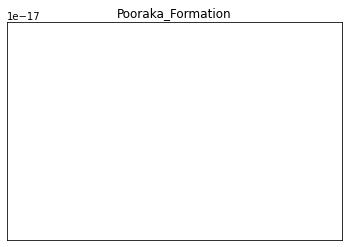

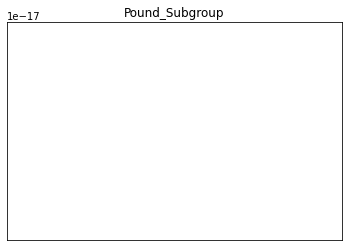

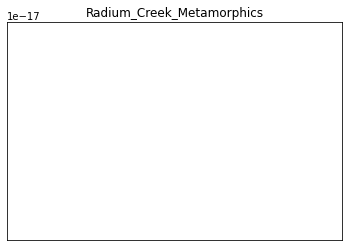

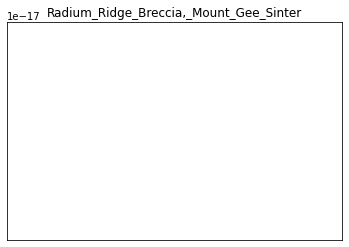

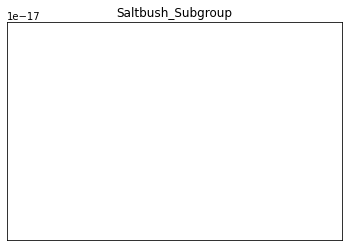

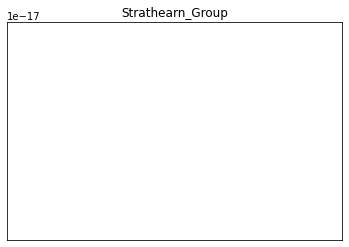

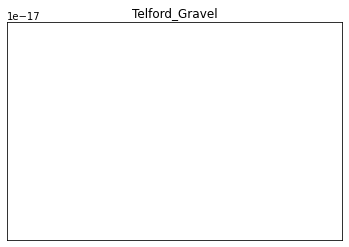

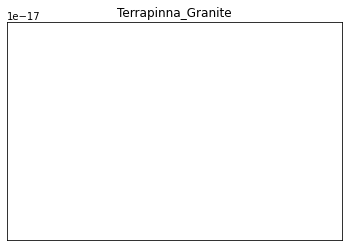

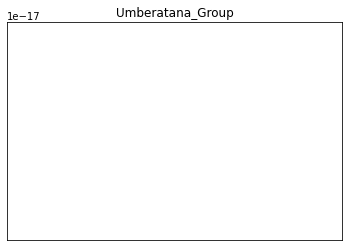

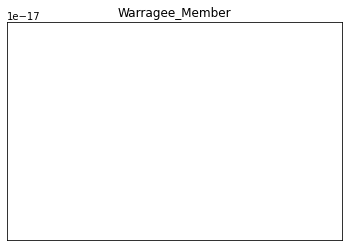

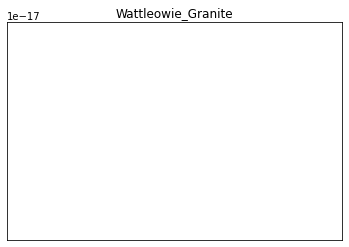

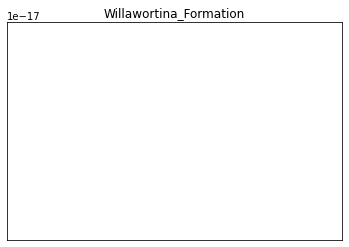

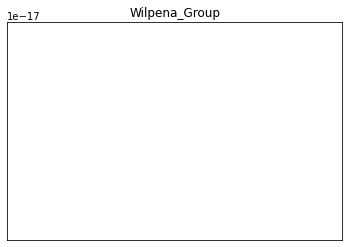

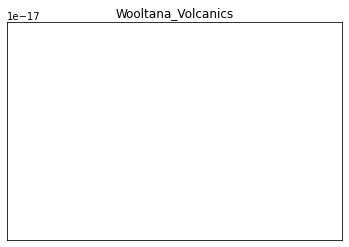

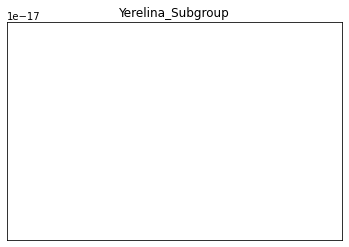

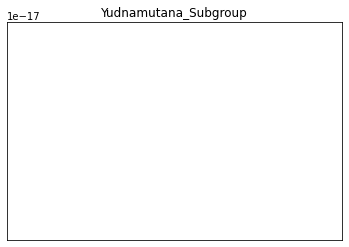

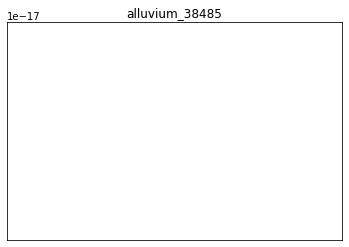

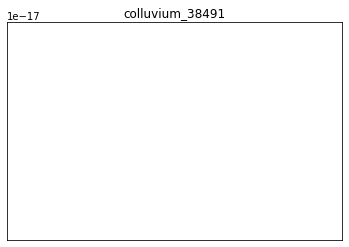

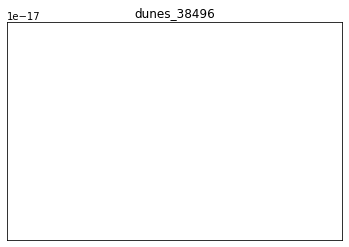

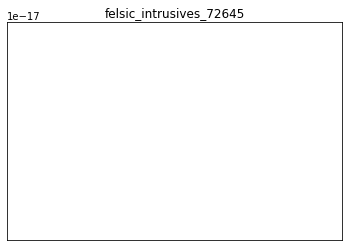

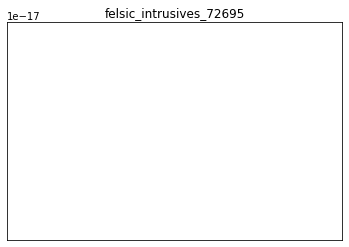

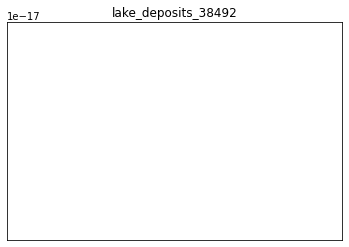

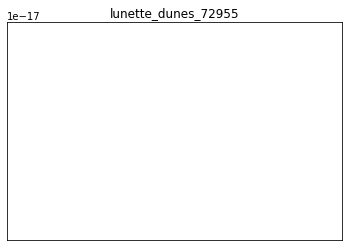

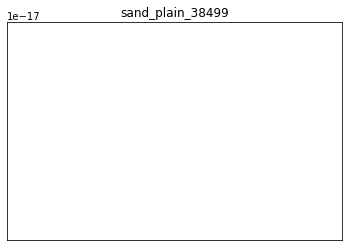

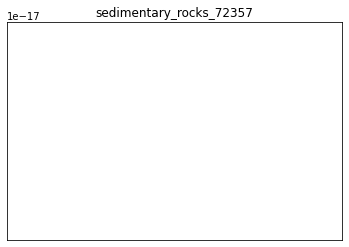

In [96]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\faults_Curnamona_UTM.shp


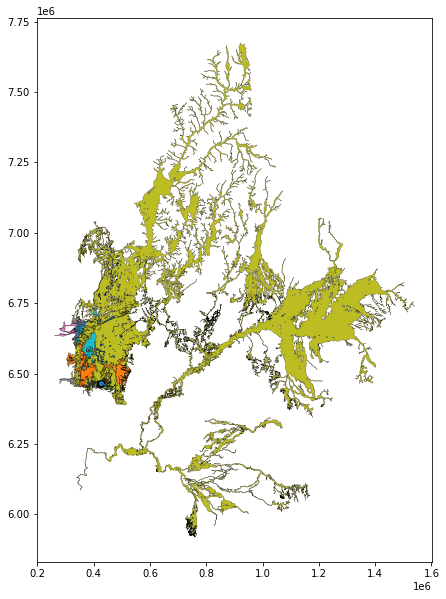

In [87]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs

sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

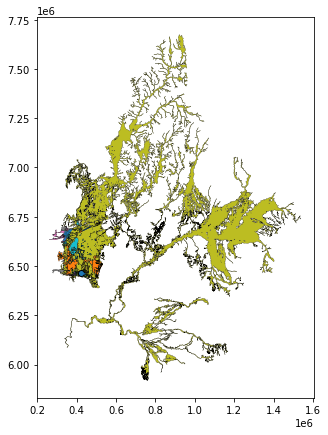

In [88]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]

if(workflow['fold_axial_traces']):
    all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
    folds_clip=m2l_utils.clip_shp(all_folds,polygo)
    if(len(folds_clip)>0):
        folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]


geol_clip=gpd.overlay(geology, polygo, how='intersection')
faults_clip=m2l_utils.clip_shp(all_faults,polygo)

structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')


if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    
geol_clip.to_file(tmp_path+'geol_clip.shp')

structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

In [104]:
#print(G,tmp_path,glabels,geol_clip,c_l)
print(glabels,c_l)

{-44: 'Arrowie_Formation', -12: 'Basso_Suite', -18: 'Bimbowrie_Suite', -23: 'Box_Bore_Granite', -38: 'British_Empire_Granite', -31: 'Burra_Group', -32: 'Callanna_Group', -21: 'Crocker_Well_Suite', -15: 'Curnamona_Group', -30: 'Emeroo_Subgroup', -47: 'Eurinilla_Formation', -3: 'Eyre_Formation', -28: 'Freeling_Heights_Quartzite,_Mount_Adams_Quartzite,_Yagdlin_Phyllite', -24: 'Golden_Pole_Granite', -7: 'Hawker_Group', -8: 'Lake_Frome_Group', -48: 'Millyera_Formation', -22: 'Moolawatana_Suite', -19: 'Mount_Neill_Granite', -4: 'Namba_Formation', -20: 'Nooldoonooldoona_Trondhjemite', -10: 'Parabarana_Sandstone', -27: 'Pepegoona_Porphyry', -43: 'Pooraka_Formation', -37: 'Pound_Subgroup', -13: 'Radium_Creek_Metamorphics', -1: 'Radium_Ridge_Breccia,_Mount_Gee_Sinter', -14: 'Saltbush_Subgroup', -16: 'Strathearn_Group', -45: 'Telford_Gravel', -26: 'Terrapinna_Granite', -33: 'Umberatana_Group', -9: 'Warragee_Member', -25: 'Wattleowie_Granite', -5: 'Willawortina_Formation', -36: 'Wilpena_Group', -2

,index,group_,min,max,ave
0,0,alluvium_38485,0.0000,0.0117,0.00585
1,1,Pooraka_Formation,0.0117,0.1260,0.06885
2,2,colluvium_38491,0.0000,2.5800,1.29000
3,3,lunette_dunes_72955,0.0000,2.5800,1.29000
4,4,lake_deposits_38492,0.0000,2.5800,1.29000
5,5,Eurinilla_Formation,0.0117,2.5800,1.29585
6,6,Millyera_Formation,0.0117,2.5800,1.29585
7,7,Arrowie_Formation,0.0117,2.5800,1.29585
8,8,Telford_Gravel,0.0117,2.5800,1.29585
9,9,Willawortina_Formation,0.0117,23.0300,11.52085


[]

{-44: 'Arrowie_Formation',
 -12: 'Basso_Suite',
 -18: 'Bimbowrie_Suite',
 -23: 'Box_Bore_Granite',
 -38: 'British_Empire_Granite',
 -31: 'Burra_Group',
 -32: 'Callanna_Group',
 -21: 'Crocker_Well_Suite',
 -15: 'Curnamona_Group',
 -30: 'Emeroo_Subgroup',
 -47: 'Eurinilla_Formation',
 -3: 'Eyre_Formation',
 -28: 'Freeling_Heights_Quartzite,_Mount_Adams_Quartzite,_Yagdlin_Phyllite',
 -24: 'Golden_Pole_Granite',
 -7: 'Hawker_Group',
 -8: 'Lake_Frome_Group',
 -48: 'Millyera_Formation',
 -22: 'Moolawatana_Suite',
 -19: 'Mount_Neill_Granite',
 -4: 'Namba_Formation',
 -20: 'Nooldoonooldoona_Trondhjemite',
 -10: 'Parabarana_Sandstone',
 -27: 'Pepegoona_Porphyry',
 -43: 'Pooraka_Formation',
 -37: 'Pound_Subgroup',
 -13: 'Radium_Creek_Metamorphics',
 -1: 'Radium_Ridge_Breccia,_Mount_Gee_Sinter',
 -14: 'Saltbush_Subgroup',
 -16: 'Strathearn_Group',
 -45: 'Telford_Gravel',
 -26: 'Terrapinna_Granite',
 -33: 'Umberatana_Group',
 -9: 'Warragee_Member',
 -25: 'Wattleowie_Granite',
 -5: 'Willawortina_Fo

group choices: 1 (more than 10 groups)
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/
49 ['Choice 0' 'lunette_dunes_72955' 'alluvium_38485' 'Pooraka_Formation'
 'sedimentary_rocks_72357' 'lake_deposits_38492' 'Millyera_Formation'
 'colluvium_38491' 'Eyre_Formation' 'Box_Bore_Granite' 'Telford_Gravel'
 'felsic_intrusives_72695' 'Arrowie_Formation' 'Eurinilla_Formation'
 'Willawortina_Formation' 'Lake_Frome_Group' 'Parabarana_Sandstone'
 'Wooltana_Volcanics' 'Namba_Formation' 'sand_plain_38499' 'dunes_38496'
 'Crocker_Well_Suite' 'Saltbush_Subgroup' 'Bimbowrie_Suite'
 'Strathearn_Group' 'Basso_Suite' 'Hawker_Group' 'Warragee_Member'
 'Pound_Subgroup' 'Wilpena_Group' 'British_Empire_Granite'
 'Yerelina_Subgroup' 'Umberatana_Group' 'Burra_Group' 'Emeroo_Subgroup'
 'Callanna_Group' 'Pepegoona_Porphyry' 'Nooldoonooldoona_Trondhjemite'
 'Yudnamutana_Subgroup'
 'Freeling_Heights_Quartzite,_Mount_Adams_Quartzite,_Yagdlin_Phyllite'
 'Mount_Neill_Granite' 'Curnamon

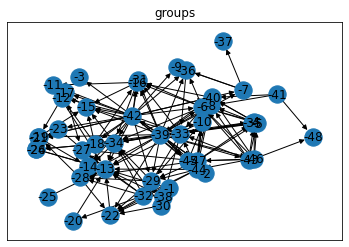

In [150]:
#import sys
#sys.path.append('../../map2loop')
import importlib
from map2loop import m2l_topology2
importlib.reload(m2l_topology2)

m2l_topology2.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [151]:
if(workflow['cover_map']):

    dtm = rasterio.open(dtm_reproj_file)
    dtb_raw = rasterio.open(dtb_grid)

    cover=gpd.read_file(cover_map_path)

    with fiona.open(cover_map_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(dtb_grid) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(dtb_clip, "w", **out_meta) as dest:
        dest.write(out_image)  

    dtb = rasterio.open(dtb_clip)
    
    m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,spacing,contact_decimate=3,use_vector=True,use_grid=True)    
    

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up?



Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

1 orientations saved to C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/orientations.csv


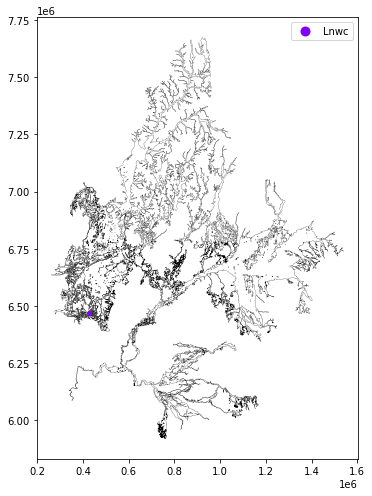

In [152]:
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])

m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',True)

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [153]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

extra orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [154]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 54671 deci_pts= 12637
saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/all_contacts.csv and C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [155]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

decimated contacts saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/contacts4.csv


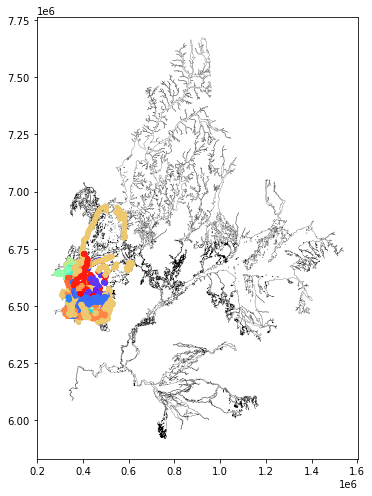

In [156]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',False)


## New interpolation test
Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for populating parts of maps where little structural data is available

In [53]:
print(scheme)
print(spacing)

scipy_rbf
500


In [81]:
basal_contacts=tmp_path+'basal_contacts.shp'
scheme = 'simple_idw'
spacing = 4000
#maybe change spacing? currently 50 could try 500
orientation_interp,contact_interp,combo_interp=m2l_interpolation.interpolation_grids(geology_file,structure_file,basal_contacts,bbox,spacing,dst_crs,scheme,super_groups,c_l)


f=open(tmp_path+'interpolated_orientations.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in orientation_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_contacts.csv','w')
f.write('X,Y,l,m,angle\n')
for row in contact_interp:
    ostr='{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_combined.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in combo_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()


['Yerelina Subgroup', 'sedimentary rocks 72357', 'Golden Pole Granite', 'Radium Creek Metamorphics', 'felsic intrusives 72695', 'Crocker Well Suite', 'Pooraka Formation', 'Mount Neill Granite', 'British Empire Granite', 'Telford Gravel', 'Parabarana Sandstone', 'Umberatana Group', 'Moolawatana Suite', 'Saltbush Subgroup', 'Pound Subgroup', 'Pepegoona Porphyry', 'Freeling Heights Quartzite, Mount Adams Quartzite, Yagdlin Phyllite', 'Nooldoonooldoona Trondhjemite', 'Box Bore Granite', 'Warragee Member', 'Wattleowie Granite', 'Burra Group', 'Radium Ridge Breccia, Mount Gee Sinter', 'Callanna Group', 'Basso Suite', 'alluvium 38485', 'Bimbowrie Suite', 'Strathearn Group', 'dunes 38496', 'Namba Formation', 'Wooltana Volcanics', 'colluvium 38491', 'Eurinilla Formation', 'sand plain 38499', 'Millyera Formation', 'Wilpena Group', 'lunette dunes 72955', 'Emeroo Subgroup', 'Yudnamutana Subgroup', 'Lake Frome Group', 'lake deposits 38492', 'Terrapinna Granite', 'Arrowie Formation', 'Willawortina F

320 439
interpolated dips


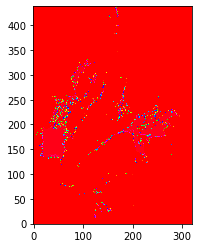

In [82]:
x=int((bbox[2]-bbox[0])/spacing)+1
y=int((bbox[3]-bbox[1])/spacing)+1
print(x,y)
dip_grid=np.ones((y,x))
dip_grid=dip_grid*-999
dip_dir_grid=np.ones((y,x))
dip_dir_grid=dip_dir_grid*-999
contact_grid=np.ones((y,x))
contact_grid=dip_dir_grid*-999
for row in combo_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    dip_grid[r,c]=float(row[5])
    dip_dir_grid[r,c]=float(row[6])

for row in contact_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    contact_grid[r,c]=float(row[4])

print('interpolated dips')
plt.imshow(dip_grid, cmap="hsv",origin='lower',vmin=-90,vmax=90)  
plt.show()

interpolated dip directions


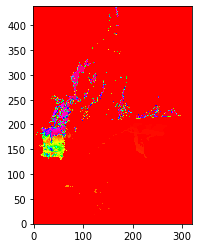

In [83]:
print('interpolated dip directions')
       
plt.imshow(dip_dir_grid, cmap="hsv",origin='lower',vmin=0,vmax=360)    
plt.show()

interpolated contacts


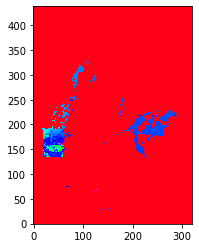

In [84]:
print('interpolated contacts')
       
plt.imshow(contact_grid, cmap="hsv",origin='lower',vmin=-360,vmax=360)    
plt.show()

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [63]:
import sys, importlib
sys.path.append('../../map2loop')
from map2loop import m2l_geometry
#del m2l_geometry
#from map2loop import m2l_geometry
importlib.reload(m2l_geometry) #fails for no apparent reason - debug these in spyder??

ModuleNotFoundError: spec not found for the module 'map2loop.m2l_geometry'

In [73]:
import importlib
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2, fmod, isnan

#import importlib
#from map2loop import m2l_topology
#importlib.reload(m2l_topology)

#from map2loop import m2l_geometry
#import map2loop
#del m2l_geometry
#import sys
#sys.path.append('../../map2loop')

#print(sys.path)

#from map2loop import m2l_geometry
#del m2l_geometry
#from map2loop import m2l_geometry
#importlib.reload(m2l_geometry)
from shapely import geometry
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString, MultiPolygon


def richard_save_faults(path_faults,output_path,dtm,dtb,dtb_null,cover_map,c_l,fault_decimate,fault_min_len,fault_dip):
    #print("now in")
    faults_clip=gpd.read_file(path_faults)
    f=open(output_path+'/faults.csv',"w")
    f.write("X,Y,Z,formation\n")
    fo=open(output_path+'/fault_orientations.csv',"w")
    fo.write("X,Y,Z,DipDirection,dip,DipPolarity,formation\n")
    #fo.write("X,Y,Z,azimuth,dip,polarity,formation\n")
    fd=open(output_path+'/fault_dimensions.csv',"w")
    fd.write("Fault,HorizontalRadius,VerticalRadius,InfluenceDistance\n")
    #fd.write("Fault_ID,strike,dip_direction,down_dip\n")
    
    split=c_l['fdipest_vals'].split(",") #convert text dips to equally spaced angles
    fault_dip_choices=np.linspace(0,90, len(split)+1)
    dip_dirs={'north':(0.0,1.0),'northeast':(.707,.707),'east':(1.0,0.0),'southeast':(.707,-.707),
              'south':(0.0,-1.0),'southwest':(-.707,-.707),'west':(-1.0,0.0),'northwest':(-.707,.707)}
    
    
    for indx,flt in faults_clip.iterrows():
        if(c_l['fault'] in flt[c_l['f']]):
            fault_name='Fault_'+str(flt[c_l['o']])
            #display(flt.geometry.type)
            if(flt.geometry.type=='LineString'):
                flt_ls=LineString(flt.geometry)
                dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                strike=sqrt((dlsx*dlsx)+(dlsy*dlsy))
                if(strike>fault_min_len):
                    i=0
                    saved=0
                    for afs in flt_ls.coords:
                        if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                            if(saved==0):
                                p1x=afs[0]
                                p1y=afs[1]
                            elif(saved==1):
                                p2x=afs[0]
                                p2y=afs[1]
                            elif(saved==2):
                                p3x=afs[0]
                                p3y=afs[1]
                                # avoids narrow angles in fault traces which geomodeller refuses to solve
                                # should really split fault in two at apex, but life is too short
                                if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                    break
                            elif(saved>2):
                                p1x=p2x
                                p1y=p2y
                                p2x=p3x
                                p2y=p3y
                                p3x=afs[0]
                                p3y=afs[1]
                                # avoids narrow angles in fault traces which geomodeller refuses to solve
                                # should really split fault in two at apex, but life is too short
                                if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                    break 
                            saved=saved+1
                            locations=[(afs[0],afs[1])]     
                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                            # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                            #if(i==0 or i==len(flt_ls.coords)-1):
                            #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                            #else:
                            ostr="{},{},{},{}\n"\
                                 .format(afs[0],afs[1],height,fault_name)
                            #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                            f.write(ostr)                
                        i=i+1  
                    if(dlsx==0.0 or dlsy == 0.0):
                        continue
                    lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                    azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                    locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     
                    height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                    
                    if(flt[c_l['o']]=='-1'):
                        print(flt[c_l['o']],c_l['fdip'],flt[c_l['fdip']],c_l['fdipnull'],c_l['fdipest'],
                          flt[c_l['fdipest']],c_l['fdipest_vals'])
                    
                    if(flt[c_l['fdip']]==c_l['fdipnull']): # null specifc dip defined
                        if(not str(flt[c_l['fdipest']])=='None'): #  dip estimate defined
                            i=0
                            for choice in split:
                                if(flt[c_l['o']]=='-1'):
                                    print(choice)
                                if(choice == flt[c_l['fdipest']]):
                                    fault_dip=int(fault_dip_choices[i+1])
                                    if(flt[c_l['o']]=='-1'):
                                        print('found_dip',fault_dip)
                                i=i+1
                        else:
                            if(fault_dip == -999): # random flag
                                fault_dip=random.randint(60,90)
                    else:
                        print( flt[c_l['fdip']])
                        if flt[c_l['fdip']] == "None" or flt[c_l['fdip']] is None:
                            fault_dip = 90
                        else:
                            fault_dip=int(flt[c_l['fdip']]) # specific dip defined
                    
                    if(c_l['fdipdir_flag']=='num'): # numeric dip direction defined
                        azimuth=flt[c_l['fdipdir']]
                    elif(not str(flt[c_l['fdipdir']])=='None'): # alpha dip direction defined
                        dotprod=degrees(acos((-lsx*dip_dirs[flt[c_l['fdipdir']]][0])+(lsy*dip_dirs[flt[c_l['fdipdir']]][1])))
                        if(dotprod>45):
                            fault_dip=-fault_dip

                        
                    ostr="{},{},{},{},{},{},{}\n"\
                         .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],
                                 height,azimuth,fault_dip,1,fault_name)
                    #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                    fo.write(ostr)
                    strike=strike*1.25
                    ostr="{},{},{},{}\n"\
                         .format(fault_name,strike/2,strike,strike/4.0)
                    #ostr=fault_name+","+str(strike/2)+","+str(strike)+","+str(strike/4.0)+"\n"
                    fd.write(ostr)
            elif(flt.geometry.type=='MultiLineString' or flt.geometry.type=='GeometryCollection' ): #shouldn't happen any more
                sum_strike=0
                first=True
                for pline in flt.geometry:
                    flt_ls=LineString(pline)
                    dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                    dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                    sum_strike=sum_strike+sqrt((dlsx*dlsx)+(dlsy*dlsy))  
                    if(first):
                        firstx=flt_ls.coords[0][0]
                        firsty=flt_ls.coords[0][1]
                    lastx=flt_ls.coords[0][0]
                    lasty=flt_ls.coords[0][1]
                ostr="{},{},{},{}\n"\
                         .format(fault_name,sum_strike/2,sum_strike,sum_strike/4.0)    
                #ostr=fault_name+","+str(sum_strike/2)+","+str(sum_strike)+","+str(sum_strike/4.0)+"\n"
                fd.write(ostr) 
                               
                dlsx=firstx-lastx
                dlsy=firsty-lasty
                if(dlsx==0.0 or dlsy == 0.0):
                        continue            

                lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     # should be mid-fault not mid fault segemnt but probs doesnt matter
                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                ostr="{},{},{},{},{},{},{},\n"\
                         .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],height,azimuth,fault_dip,1,fault_name)
                #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                fo.write(ostr)

                for pline in flt.geometry:
                    #display(pline)
                    #display(flt)
                    flt_ls=LineString(pline)
                    dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                    dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                    if(dlsx==0.0 or dlsy == 0.0):
                        continue
                  
                    if(sum_strike>fault_min_len):
                        i=0
                        saved=0
                        for afs in flt_ls.coords:
                            if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                                if(saved==0):
                                    p1x=afs[0]
                                    p1y=afs[1]
                                elif(saved==1):
                                    p2x=afs[0]
                                    p2y=afs[1]
                                elif(saved==2):
                                    p3x=afs[0]
                                    p3y=afs[1]
                                    # avoids narrow angles in fault traces which geomodeller refuses to solve
                                    # should really split fault in two at apex, but life is too short
                                    if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                        break
                                elif(saved>2):
                                    p1x=p2x
                                    p1y=p2y
                                    p2x=p3x
                                    p2y=p3y
                                    p3x=afs[0]
                                    p3y=afs[1]
                                    # avoids narrow angles in fault traces which geomodeller refuses to solve
                                    # should really split fault in two at apex, but life is too short
                                    if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                        break 
                                saved=saved+1
                                locations=[(afs[0],afs[1])]     
                                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                                #if(i==0 or i==len(flt_ls.coords)-1):
                                #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                                #else:
                                ostr="{},{},{},{}\n"\
                                     .format(afs[0],afs[1],height,fault_name)
                                #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                                f.write(ostr)                
                            i=i+1  


    f.close()
    fo.close()
    fd.close()
    print("fault orientations saved as",output_path+'fault_orientations.csv')
    print("fault positions saved as",output_path+'faults.csv')
    print("fault dimensions saved as",output_path+'fault_dimensions.csv')



richard_save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


None
None
None
None
None
None
None
None
fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_orientations.csv
fault positions saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/faults.csv
fault dimensions saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_dimensions.csv


fault displacement estimates saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/fault_displacements3.csv
near-fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/ex_f_combo_full.csv
near-fault orientations saved as C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/ex_f_combo_full.csv


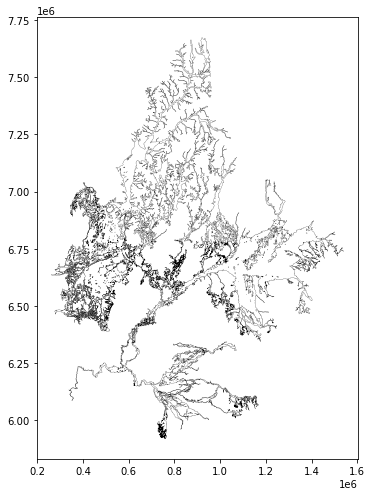

In [89]:
import warnings
warnings.filterwarnings('ignore')

faults=pd.read_csv(output_path+'faults.csv')
faults_len=len(faults)

if(faults_len>0):
    m2l_interpolation.process_fault_throw_and_near_faults_from_grid(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,bbox,
                                                                scheme,dip_grid,dip_dir_grid,x,y,spacing)

    m2l_utils.plot_points(output_path+'fault_displacements3.csv',geol_clip, 'apparent_displacement','X','Y',False)


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [93]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10

def richard_process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,cover_map,pluton_form,pluton_dip,contact_decimate,c_l):
    
    groups=np.genfromtxt(tmp_path+'groups.csv',delimiter=',',dtype='U100')

    if(len(groups.shape)==1):
        ngroups=len(groups)-1
        orig_ngroups=ngroups

        gp_ages=np.zeros((1000,3))
        gp_names=np.zeros((1000),dtype='U100')

        for i in range (0,ngroups):
            gp_ages[i,0]=-1e6 # group max_age
            gp_ages[i,1]=1e6 # group min_age
            gp_ages[i,2]=i # group index
            gp_names[i]=groups[i+1].replace("\n","")
    else:
        ngroups=len(groups[0])-1
        orig_ngroups=ngroups

        gp_ages=np.zeros((1000,3))
        gp_names=np.zeros((1000),dtype='U100')

        for i in range (0,ngroups):
            gp_ages[i,0]=-1e6 # group max_age
            gp_ages[i,1]=1e6 # group min_age
            gp_ages[i,2]=i # group index
            gp_names[i]=groups[0][i+1].replace("\n","")
        #print(i,gp_names[i])

    #print(local_paths)  

    allc=open(output_path+'all_ign_contacts.csv',"w")
    allc.write('GROUP_,id,x,y,z,code\n')
    ac=open(output_path+'ign_contacts.csv',"w")
    ac.write("X,Y,Z,formation\n")
    ao=open(output_path+'ign_orientations_'+pluton_form+'.csv',"w")
    ao.write("X,Y,Z,azimuth,dip,polarity,formation\n")
    #print(output_path+'ign_orientations_'+pluton_form+'.csv')
    j=0
    allpts=0
    ls_dict={}
    ls_dict_decimate={}
    id=0
    for indx,ageol in geol_clip.iterrows(): 
        ades=str(ageol[c_l['ds']])
        arck=str(ageol[c_l['r1']])
        if(str(ageol[c_l['g']])=='None'):
            agroup=str(ageol[c_l['c']])
        else:
            agroup=str(ageol[c_l['g']])
        
        for i in range(0,ngroups):
            if (gp_names[i]==agroup):
                if(int(ageol[c_l['max']]) > gp_ages[i][0]  ):
                    gp_ages[i][0] = ageol[c_l['max']]
                if(int(ageol[c_l['min']]) < gp_ages[i][1]  ):
                    gp_ages[i][1] = ageol[c_l['min']]
        if(c_l['intrusive'] in arck and c_l['sill'] not in ades):
            newgp=str(ageol[c_l['c']])
            #print(newgp)
            if(str(ageol[c_l['g']])=='None'):
                agp=str(ageol[c_l['c']])
            else:
                agp=str(ageol[c_l['g']])

            if(not newgp  in gp_names):
                gp_names[ngroups]=newgp
                gp_ages[ngroups][0]=ageol[c_l['max']]
                gp_ages[ngroups][1]=ageol[c_l['min']]
                gp_ages[ngroups][2]=ngroups
                ngroups=ngroups+1
                
            neighbours=[]
            j+=1
            central_age=ageol[c_l['min']]    #absolute age of central polygon
            central_poly=ageol.geometry
            for ind,bgeol in geol_clip.iterrows(): #potential neighbouring polygons  
                if(ageol.geometry!=bgeol.geometry): #do not compare with self
                    if (ageol.geometry.intersects(bgeol.geometry)): # is a neighbour
                        neighbours.append([(bgeol[c_l['c']],bgeol[c_l['min']],bgeol[c_l['r1']],bgeol[c_l['ds']],bgeol.geometry)])  
            #display(neighbours)
            if(len(neighbours) >0):
                for i in range (0,len(neighbours)):
                    if((c_l['intrusive'] in neighbours[i][0][2] and c_l['sill'] not in ades) 
                       #or ('intrusive' not in neighbours[i][0][2]) and neighbours[i][0][1] > central_age ): # neighbour is older than central
                       or (c_l['intrusive'] not in neighbours[i][0][2]) and neighbours[i][0][1]  ): # neighbour is older than central
                        older_polygon=neighbours[i][0][4]
                        if(not central_poly.is_valid ):
                            central_poly = central_poly.buffer(0)
                        if(not older_polygon.is_valid):
                            older_polygon = older_polygon.buffer(0)
                        LineStringC = central_poly.intersection(older_polygon)
                        if(LineStringC.wkt.split(" ")[0]=='MULTIPOLYGON' or 
                           LineStringC.wkt.split(" ")[0]=='POLYGON'): #ignore polygon intersections for now, worry about them later!
                            print(ageol[c_l['o']],"debug:",LineStringC.wkt.split(" ")[0])
                            continue

                        elif(LineStringC.wkt.split(" ")[0]=='MULTILINESTRING' or LineStringC.wkt.split(" ")[0]=='GEOMETRYCOLLECTION'):
                            k=0
                            ls_dict[id] = {"id": id,c_l['c']:newgp,c_l['g']:newgp, "geometry": LineStringC}
                            id=id+1
                            for lineC in LineStringC: #process all linestrings
                                if(lineC.wkt.split(" ")[0]=='LINESTRING'):
                                    if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                        locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                        if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                           lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                                ostr="{},{},{},{}\n"\
                                                      .format(lineC.coords[0][0],lineC.coords[0][1],height,newgp.replace(" ","_").replace("-","_"))
                                                #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                                ac.write(ostr)
                                                allc.write(agp+","+str(ageol[c_l['o']])+","+ostr)
                                                ls_dict_decimate[allpts] = {"id": allpts,c_l['c']:newgp,c_l['g']:newgp, "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                                allpts+=1 
                                        else:
                                            continue
                                    else:
                                        if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                                lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                            ostr="{},{},{},{}\n"\
                                                  .format(lineC.coords[0][0],lineC.coords[0][1],height,newgp.replace(" ","_").replace("-","_"))
                                            #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                            #ls_dict_decimate[allpts] = {"id": id,"CODE":ageol['CODE'],"GROUP_":ageol['GROUP_'], "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                            allc.write(agp+","+str(ageol[c_l['o']])+","+ostr)
                                            allpts+=1

                                    if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                        dlsx=lineC.coords[0][0]-lineC.coords[1][0]
                                        dlsy=lineC.coords[0][1]-lineC.coords[1][1]
                                        lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                        lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))                                        

                                        locations=[(lineC.coords[0][0],lineC.coords[0][1])]
                                        height= m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                        azimuth=(180+degrees(atan2(lsy,-lsx)))%360 #normal to line segment
                                        testpx=lineC.coords[0][0]-lsy # pt just a bit in/out from line
                                        testpy=lineC.coords[0][0]+lsx

                                        if(ageol.geometry.type=='Polygon'):
                                            if Polygon(ageol.geometry).contains(Point(testpx, testpy)):
                                                azimuth=(azimuth-180)%360
                                        else:
                                            if MultiPolygon(ageol.geometry).contains(Point(testpx, testpy)):
                                                azimuth=(azimuth-180)%360

                                        if(pluton_form=='saucers'):
                                            polarity=1
                                            #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                        elif(pluton_form=='domes'):
                                            polarity=0
                                            azimuth=(azimuth-180)%360
                                            #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                        elif(pluton_form=='pendant'):
                                            polarity=0
                                            #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                        else: #pluton_form == batholith
                                            polarity=1
                                            azimuth=(azimuth-180)%360
                                            #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                        ostr="{},{},{},{},{},{},{}\n"\
                                                  .format(lineC.coords[0][0],lineC.coords[0][1],height,azimuth,pluton_dip,polarity,newgp.replace(" ","_").replace("-","_"))
                                        ao.write(ostr)

                                    k+=1
                        elif(LineStringC.wkt.split(" ")[0]=='LINESTRING'): # apparently this is not needed
                            k=0
                            lineC=LineString(LineStringC)
                            if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                locations=[(lineC.coords[0][0],lineC.coords[0][1])] #doesn't like point right on edge?
                                if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                   lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                        height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                        ostr="{},{},{},{}\n"\
                                                  .format(lineC.coords[0][0],lineC.coords[0][1],height,newgp.replace(" ","_").replace("-","_"))
                                        #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                        ac.write(ostr)
                                        allc.write(agp+","+str(ageol[c_l['o']])+","+ostr)
                                        ls_dict_decimate[allpts] = {"id": allpts,c_l['c']:newgp,c_l['g']:newgp, "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                        allpts+=1 
                                else:
                                    continue
                            else:
                                if(lineC.coords[0][0] > dtm.bounds[0] and lineC.coords[0][0] < dtm.bounds[2] and  
                                        lineC.coords[0][1] > dtm.bounds[1] and lineC.coords[0][1] < dtm.bounds[3]):       
                                    height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                    ostr="{},{},{},{}\n"\
                                          .format(lineC.coords[0][0],lineC.coords[0][1],height,newgp.replace(" ","_").replace("-","_"))
                                    #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+height+","+newgp.replace(" ","_").replace("-","_")+"\n"
                                    #ls_dict_decimate[allpts] = {"id": id,"CODE":ageol['CODE'],"GROUP_":ageol['GROUP_'], "geometry": Point(lineC.coords[0][0],lineC.coords[0][1])}
                                    allc.write(agp+","+str(ageol[c_l['o']])+","+ostr)
                                    allpts+=1
                            
                            if(m2l_utils.mod_safe(k,contact_decimate)==0 or k==int((len(LineStringC)-1)/2) or k==len(LineStringC)-1): #decimate to reduce number of points, but also take second and third point of a series to keep gempy happy
                                dlsx=lineC.coords[0][0]-lineC.coords[1][0]
                                dlsy=lineC.coords[0][1]-lineC.coords[1][1]
                                lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                                lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))                                        

                                locations=[(lineC.coords[0][0],lineC.coords[0][1])]
                                height= m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                azimuth=(180+degrees(atan2(lsy,-lsx)))%360 #normal to line segment
                                testpx=lineC.coords[0][0]-lsy # pt just a bit in/out from line
                                testpy=lineC.coords[0][0]+lsx

                                if(ageol.geometry.type=='Polygon'):
                                    if Polygon(ageol.geometry).contains(Point(testpx, testpy)):
                                        azimuth=(azimuth-180)%360
                                else:
                                    if MultiPolygon(ageol.geometry).contains(Point(testpx, testpy)):
                                        azimuth=(azimuth-180)%360
                                        
                                if(pluton_form=='saucers'):
                                    polarity=1
                                    #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                elif(pluton_form=='domes'):
                                    polarity=0
                                    azimuth=(azimuth-180)%360
                                    #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                elif(pluton_form=='pendant'):
                                    polarity=0
                                    #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",0,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                else: #pluton_form == batholith
                                    polarity=1
                                    azimuth=(azimuth-180)%360
                                    #ostr=str(lineC.coords[0][0])+","+str(lineC.coords[0][1])+","+str(height)+","+str(azimuth)+","+str(pluton_dip)+",1,"+newgp.replace(" ","_").replace("-","_")+"\n"
                                ostr="{},{},{},{},{},{},{}\n"\
                                          .format(lineC.coords[0][0],lineC.coords[0][1],height,azimuth,pluton_dip,polarity,newgp.replace(" ","_").replace("-","_"))
                                ao.write(ostr)
                            k+=1                                
                        elif(LineStringC.wkt.split(" ")[0]=='POINT'): # apparently this is not needed
                            k=0
                            #print("debug:POINT")
                            k+=1
                        else:
                            k=0
                            #print(LineStringC.wkt.split(" ")[0]) # apparently this is not needed
                            k+=1
    ac.close()
    ao.close()
    allc.close()

      
    an=open(tmp_path+'groups2.csv',"w")

    for i in range (0,orig_ngroups):
        print(i,gp_names[i].replace(" ","_").replace("-","_"))
        an.write(gp_names[i].replace(" ","_").replace("-","_")+'\n')
    an.close()

    all_sorts=pd.read_csv(tmp_path+'all_sorts.csv',",")

    as_2=open(tmp_path+'all_sorts.csv',"r")
    contents =as_2.readlines()
    as_2.close

    all_sorts_file=open(tmp_path+'all_sorts2.csv',"w")
    all_sorts_file.write('index,group number,index in group,number in group,code,group\n')
    j=1
    if(cover_map):  
        all_sorts_file.write('-1,0,1,1,cover,cover\n')

    for i in range(1,len(all_sorts)+1):    
        all_sorts_file.write(contents[i]) #don't write out if already there in new groups list#
        
    all_sorts_file.close()
    print('pluton contacts and orientations saved as:')
    print(output_path+'ign_contacts.csv')
    print(output_path+'ign_orientations_'+pluton_form+'.csv')



#m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)
richard_process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)


0 _Mount_Adams_Quartzite
1 _Yagdlin_Phyllite;Mount_Neill_Granite;Curnamona_Group;felsic_intrusives_72645;Terrapinna_Granite;Gol
2 _Mount_Gee_Sinter;Moolawatana_Suite;Radium_Creek_Metamorphics
pluton contacts and orientations saved as:
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/ign_contacts.csv
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\output/ign_orientations_domes.csv


## Extract faults and basal contacts of groups from seismic section

In [94]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,workflow['cover_map'],surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)


## Propagate dips along contacts


In [95]:
if(workflow['contact_dips']):
    orientations=pd.read_csv(output_path+'orientations.csv',",")
    contact_dip=-999
    contact_orientation_decimate=5
    m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                            dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip,dip_grid,spacing,bbox)

## Estimate formation thickness and normalised formation thickness

In [96]:
if(workflow['formation_thickness']):

    geology_file=tmp_path+'basal_contacts.shp'
    contact_decimate=5
    null_scheme='null'
    m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)
    
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)
    m2l_geometry.normalise_thickness(output_path)
    
    m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',False)


## Creates fold axial trace points

In [97]:
if(workflow['fold_axial_traces']):

    m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

    #Save fold axial trace near-hinge orientations
    fat_step=750         # how much to step out normal to fold axial trace
    close_dip=-999       #dip to assign to all new orientations (-999= use local interpolated dip)

    m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
                                                     fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)


DriverError: C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/folds_clip.shp: No such file or directory

## Preprocess data to ensure it meets modelling requirements

In [98]:
m2l_geometry.tidy_data(output_path,tmp_path,use_gcode3,use_interpolations,use_fat,pluton_form,inputs,workflow)
dtm.close()
if(workflow['cover_map']):
    dtb.close()

No interpolated orientations available for merging.
No fat orientations available for merging.
no orientations for the group: dunes_38496
no orientations for the group: Yudnamutana_Subgroup
no orientations for the group: Moolawatana_Suite
no orientations for the group: Wattleowie_Granite
no orientations for the group: Willawortina_Formation
no orientations for the group: Crocker_Well_Suite
no orientations for the group: Bimbowrie_Suite
no orientations for the group: Umberatana_Group
no orientations for the group: Wooltana_Volcanics
no orientations for the group: Pound_Subgroup
no orientations for the group: Mount_Neill_Granite
no orientations for the group: Yerelina_Subgroup
no orientations for the group: Burra_Group
no orientations for the group: Parabarana_Sandstone
no orientations for the group: Strathearn_Group
no orientations for the group: British_Empire_Granite
no orientations for the group: lake_deposits_38492
no orientations for the group: Telford_Gravel
no orientations for th

## Calculate polarity of original bedding orientation data (not used yet in final calc)

In [99]:
if(workflow['polarity']):
    m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

    m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True)


## Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [100]:
if(workflow['strat_offset']):
    m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True)
    m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True)


## Analyse fault-fault topology

cycles []


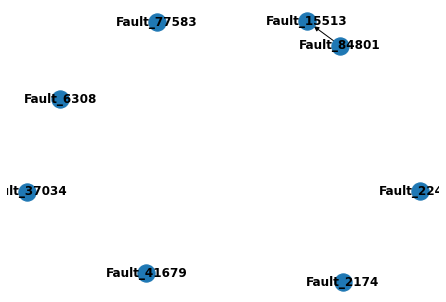

In [101]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [ ]:
if(workflow['model_engine']=='geomodeller'):
    from datetime import datetime
    import shutil

    
    m2l_topology.check_near_fault_contacts(tmp_path+'faults_clip.shp',tmp_path+'all_sorts_clean.csv',
                                           output_path+'fault_dimensions.csv',output_path+'group-fault-relationships.csv',
                                           output_path+'contacts_clean.csv',c_l,dst_crs)

    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name=test_data_name+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(test_data_path+'/'+model_name)
    save_faults=True
    compute_etc=True
    t1 = time.time()
    m2l_export.loop2geomodeller(model_name,test_data_path,tmp_path,output_path,'../dtm/dtm_rp.tif',bbox,
                                model_top,model_base,save_faults,compute_etc,workflow)
    t2 = time.time()
    os.chdir(test_data_path+'/'+model_name)
    %system geomodellerbatch.exe -batch m2l.taskfile
    t3 = time.time()
    #%system geomodellerbatch.exe -batch m2l_compute.taskfile
    t4 = time.time()
    print("m2l",(t1-t0)/60.0,"export process",(t2-t1)/60.0,"batch process",(t3-t2)/60.0,"batch calculate",(t4-t3)/60.0,"minutes")
    #shutil.copy('../tmp','.')
    #shutil.copy('../output','.')
    #shutil.copy('../graph','.')
    #shutil.copy('../dtm','.')
    os.chdir('..')

# loopstructural test

In [ ]:
if(workflow['model_engine']=='loopstructural'):
    f=open(tmp_path+'bbox.csv','w')
    f.write('minx,miny,maxx,maxy,lower,upper\n')
    ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
    f.write(ostr)
    f.close()
    t1 = time.time()
    import lavavu
    from pyamg import solve

    m2l_export.loop2LoopStructural(output_path+'formation_thicknesses.csv',output_path+'orientations.csv',output_path+'contacts4.csv',tmp_path,bbox)
    t2 = time.time()
    print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")

In [127]:
def richard_loop2gempy(test_data_name: str, tmp_path: str, vtk_path: str, orientations_file: str,
               contacts_file: str, groups_file:str,
               bbox: tuple, model_base: float, model_top: float, vtk: bool, dtm_reproj_file:str = None,
               va=None,
               verbose: bool = False, compute: bool = True):
    """

    :param test_data_name:
    :param tmp_path:
    :param vtk_path:
    :param orientations_file:
    :param contacts_file:
    :param groups_file:
    :param bbox:
    :param model_base:
    :param model_top:
    :param vtk:
    :param dtm_reproj_file:
    :param va: vertical anisotropy. Factor by which all Z coordinates are multiplied by
    :param verbose:
    :param compute:
    :return:
    """
    import gempy as gp
    from gempy import plot
    print("this one running")

    geo_model = gp.create_model(test_data_name)

    # If depth coordinates are much smaller than XY the whole system of equations becomes very unstable. Until
    # I fix it properly in gempy this is a handcrafted hack
    if va is None:
        va = (float(bbox[0]) - float(bbox[2])) / (model_base - model_top)/2

        if va < 3:
            va = 0
        else:
            print('The vertical exageration is: ', va)

    gp.init_data(geo_model, extent=[bbox[0], bbox[2], bbox[1], bbox[3], model_base * va, model_top * va],
                 resolution=(50, 50, 50),
                 path_o=orientations_file,
                 path_i=contacts_file)

    geo_model.modify_surface_points(geo_model.surface_points.df.index, Z=geo_model.surface_points.df['Z'] * va)

    if dtm_reproj_file is not None:
    #if dtm_reproj_file is None:
        # Load reprojected topography to model

        fp = dtm_reproj_file
        geo_model.set_topography(source='gdal', filepath=fp)
        #geo_model.set_topography()
        #geo_model.set_topography(source='random')
		
        print("va", va, "fp",fp)
        print(type(geo_model.grid))
        # Rescaling topography:
        #print("tv b4", geo_model.grid.topography.shape)
        ####geo_model.grid.topography.values[:, 2] *= va
        geo_model._grid.topography.values[:, 2] *= va
        #print("va", geo_model.grid.topography.values)
        ####geo_model.grid.update_grid_values()
        ####geo_model.update_from_grid()
        geo_model._grid.update_grid_values()
        geo_model.update_from_grid()

    # Pile processing:
    print(groups_file)
    contents = np.genfromtxt(groups_file,
                             delimiter=';', dtype='U100')

    # Init dictionary Series:Surfaces
    map_series_to_surfaces = {}
    choice = 0
    for group in contents:
        # Reading surfaces groups
        #surfaces_g = np.atleast_2d(np.genfromtxt(tmp_path + group + '.csv', delimiter=',', dtype='U100'))
        print(group)
        
        surfaces_g = np.atleast_2d(np.genfromtxt(tmp_path + group + '.csv', delimiter=';', dtype='U100'))
        print(surfaces_g)

        # Check if there are several choices
        if surfaces_g.shape[1] > 1:
            surfaces_g = surfaces_g[choice]
        # Deleting the first element since it is not a surface
        surfaces_g = surfaces_g[1:]
        # Creating the mapping dictionary
        map_series_to_surfaces[group] = surfaces_g.tolist()

    if verbose is True:
        print(map_series_to_surfaces)

    # Setting pile to model
    gp.map_series_to_surfaces(geo_model, map_series_to_surfaces, remove_unused_series=False)

    if('Default series' in map_series_to_surfaces):

        #    Removing related data
        del_surfaces = geo_model.surfaces.df.groupby('series').get_group('Default series')['surface']
        geo_model.delete_surfaces(del_surfaces, remove_data=True)

        # Removing series that have not been mapped to any surface
        geo_model.delete_series('Default series')

    if compute is True:
        gp.set_interpolator(geo_model, theano_optimizer='fast_run', dtype='float64')
        gp.compute_model(geo_model)

    # Visualise Model
    p3d = gp.plot_3d(geo_model, plotter_type='background', notebook=False)

    p3d3 = gp.plot_3d(geo_model, notebook=True)
	

    # Save model as vtk
    if vtk:
        vtkexp = gp._plot.export_to_vtk(geo_model, path=vtk_path, name=test_data_name + '.vtk', voxels=False, block=None,
                              surfaces=True)

    return geo_model


# gempy test

this one running
The vertical exageration is:  145.18053310360867
Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
va 145.18053310360867 fp C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\dtm/dtm_rp.tif
<class 'gempy.core.model.RestrictingWrapper'>
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/groups_clean.csv
Mount_Neill_Granite
[['Choice 0,Mgbn']]
Curnamona_Group
[['Choice 0,Lnwc']]
felsic_intrusives_72645
[['Choice 0,Lg']]
Terrapinna_Granite
[['Choice 0,Mgmp']]
Moolawatana_Suite
[['Choice 0,Mgm']]
Radium_Creek_Metamorphics
[['Choice 0,Lnrc']]
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                    values

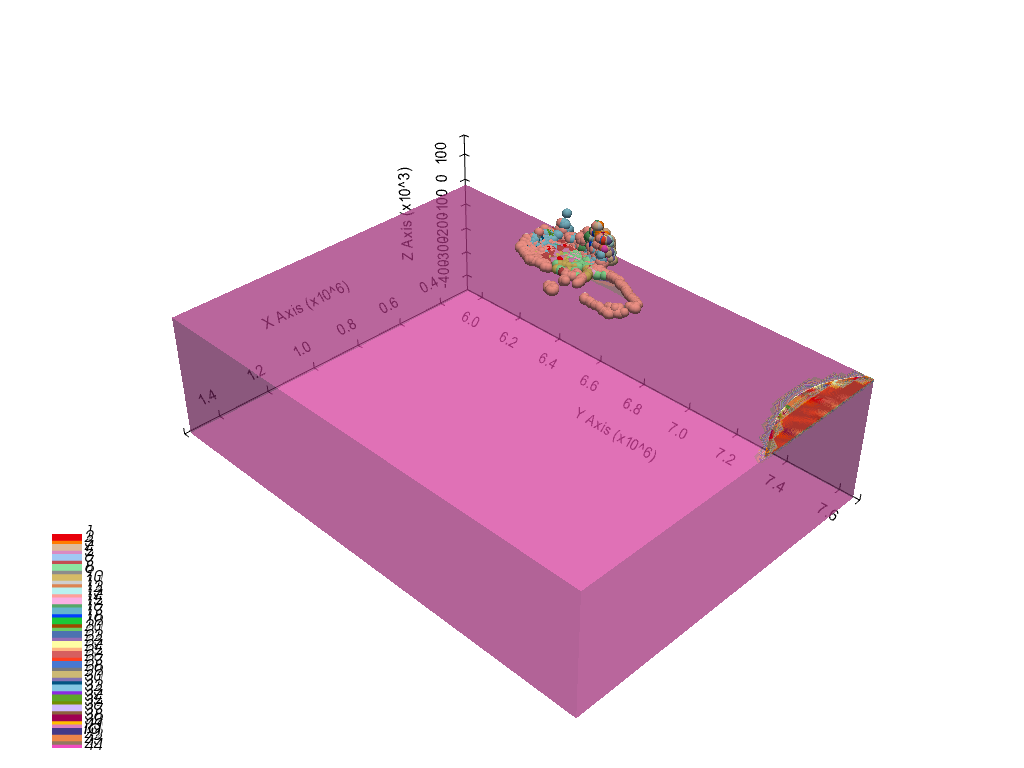

In [118]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    #import importlib
    #importlib.reload(m2l_export)


    vtk=False
    richard_loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                    output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                    bbox,model_base, model_top,vtk,dtm_reproj_file)

# noddy test

In [ ]:
if(workflow['model_engine']=='noddy'):

    import pynoddy.history
    import networkx as nx
    #Read a csv file with the vertices of the faults
    #see notes in the bottom of the notebook for instructions on how to generate such vertices files
    t1 = time.time()
    
    scale=1.5 #  scales mdoel to fit predefined volume (complete hack)
    
    # load fault coordinates
    faultsxy=pd.read_csv(output_path+'faults.csv')

    #load fault graph, remove cyclic loops and find (non-unique) age-ordered list 
    G=nx.read_gml(tmp_path+"fault_network.gml")
    cycles=list(nx.simple_cycles(G))
    for c in cycles:
        G.remove_edge(c[0], c[1])
    faults=nx.topological_sort(G)

    # write out Noe format format file
    file=open(tmp_path+'faults_for_noe.csv','w')
    file.write('id,DipDirecti,X,Y\n')
    for f in faults:
            fxy=faultsxy[faultsxy["formation"]==f.replace("\n","")]
            #display(f.replace("\n",""))
            for ind,xy in fxy.iterrows():
                ostr=f.replace('\n','')+',West,'+str(xy['X']/scale)+','+str(xy['Y']/scale)+'\n'
                file.write(ostr)
    file.close()
    
    csvfile = tmp_path+'faults_for_noe.csv'
    CsvFaultData = pd.read_csv(csvfile)

    #how much does the fault slip relative to the fault length
    SlipParam = 0.1

    #the xyz origin of the model you will be generating
    xy_origin=[minx/scale,miny/scale, 1200-4000]

    #Get information about each parameter in Noddy format
    #The output from the function is a dictionary with lists of the fault parameters
    noddyFormattedFaultData =  pynoddy.history.setUpFaultRepresentation(CsvFaultData,
                                                        xy_origin=xy_origin, 
                                                        SlipParam=SlipParam)

    #Create a dictionary with the stratigraphy information
    StratDict = {}
    StratDict['Heights'] = [2000, 2500, 3000, 3700]
    StratDict['Names'] = ['Intrusive', 'Felsic', 'Mafic','Sed'] 
    StratDict['Density'] =  [2.65, 2.5, 2.4, 2.3] 
    StratDict['MagSus'] = [0.0015, 0.0012, 0.0018, 0.001]

    #Now make the history file
    filename = output_path+'faultmodel.his'
    noddyFormattedFaultData =  pynoddy.history.createPyNoddyHistoryFile(noddyFormattedFaultData, StratDict, filename=filename)


In [ ]:
if(workflow['model_engine']=='noddy'):
    import vtkplotter as vtkP
    import itkwidgets
    import k3d
    import pynoddy.output
    import pynoddy.history

    modelfile = output_path+'faultmodel.his'

    # Determine the path to the noddy executable
    noddy_path = '../../pynoddy-new/noddyapp/noddy_win64.exe'

    # Where you would like to place all your output files
    outputfolder = tmp_path

    # choose what software to use for visualizing the model
    #you can also choose to change to itkwidgets, k3d, False (popup), or panel
    #you might need to install packages depending on what you choose
    vtkP.settings.embedWindow('k3d') 

    # create a plot in vtkplotter
    plot = vtkP.Plotter(axes=1, bg='white', interactive=1)

    # call the plotting function
    points = pynoddy.output.CalculatePlotStructure(modelfile, plot, noddy_path, 
                                           outputfolder=outputfolder,
                                           LithologyOpacity=0.2, outputOption=0)
    plot.show(viewup='z')
    t2 = time.time()

    print("m2l",(t1-t0)/60.0,"noddy",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")


In [ ]:
LC = gpd.read_file(r'C:\Users\rscott\Downloads\LC\LC.geojson')

KeyboardInterrupt: 

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1500, in log
    self._log(level, msg, args, **kwargs)
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1575, in _log
    record = self.makeRecord(self.name, level, fn, lno, msg, args,
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1544, in makeRecord
    rv = _logRecordFactory(name, level, fn, lno, msg, args, exc_info, func,
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 318, in __init__
    self.filename = os.path.basename(pathname)
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\ntpath.py", line 216, in basename
    return split(p)[1]
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\ntpath.py", line 191,

KeyboardInterrupt: 

Exception ignored in: 'fiona._env.log_error'
Traceback (most recent call last):
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1500, in log
    self._log(level, msg, args, **kwargs)
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1575, in _log
    record = self.makeRecord(self.name, level, fn, lno, msg, args,
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 1544, in makeRecord
    rv = _logRecordFactory(name, level, fn, lno, msg, args, exc_info, func,
  File "C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\gempy\lib\logging\__init__.py", line 314, in __init__
    self.levelname = getLevelName(level)
KeyboardInterrupt: 


this one running
The vertical exageration is:  145.18053310360867
Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
va 145.18053310360867 fp C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\dtm/dtm_rp.tif
<class 'gempy.core.model.RestrictingWrapper'>
C:\Users\rscott\Documents\Exploracorn\Australia\s3\exploracorn\shapefiles\tmp/groups_clean.csv
Mount_Neill_Granite
[['Choice 0,Mgbn']]
Curnamona_Group
[['Choice 0,Lnwc']]
felsic_intrusives_72645
[['Choice 0,Lg']]
Terrapinna_Granite
[['Choice 0,Mgmp']]
Moolawatana_Suite
[['Choice 0,Mgm']]
Radium_Creek_Metamorphics
[['Choice 0,Lnrc']]
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                                    values

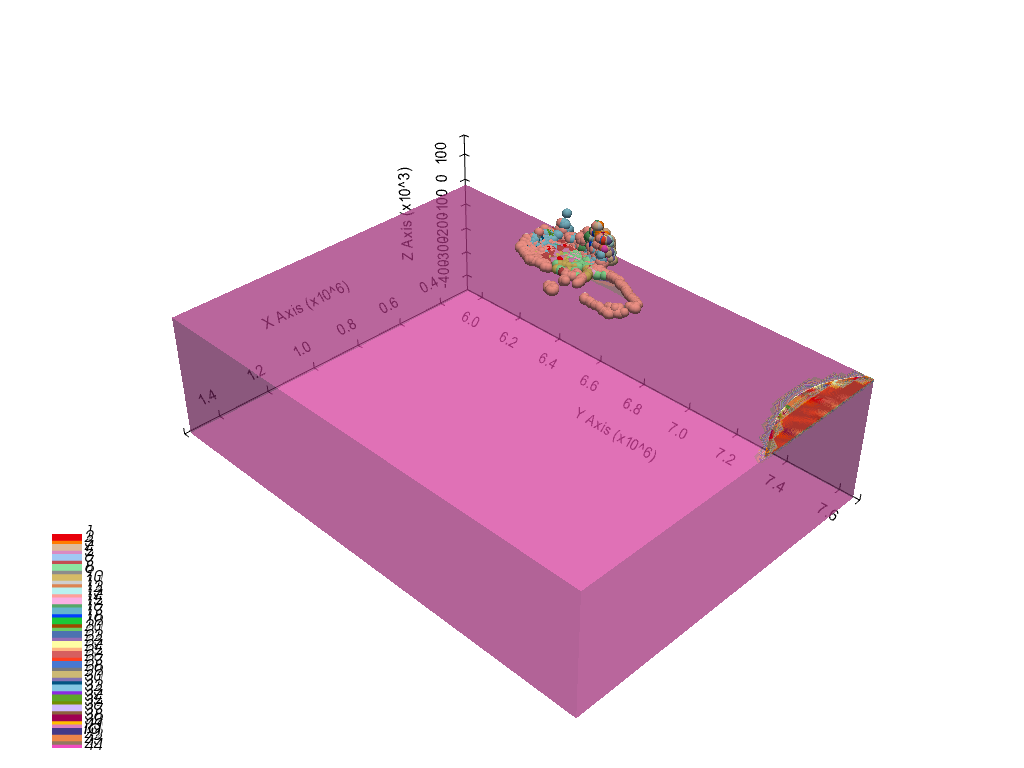

In [128]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    #import importlib
    #importlib.reload(m2l_export)


    vtk=True
    rmodel = richard_loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                    output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                    bbox,model_base, model_top,vtk,dtm_reproj_file)

In [ ]:
print(rmodel)